<h2>U.C. Introdução a Modelos Dinâmicos
<br>
<h3>Docente: Diana Aldea Mendes
<br>
<h1>Título: 
<br>Previsão da despesa alimentar num agregado familiar Espanhol (por mês)
<br>
<h4>
<b>Trabalho realizado por:<b>
<br>
<br>
<ul>
<li>Bárbara Carvalho, nº92551</li>
<br>
<li>Ricardo Santo, nº93357</li>
<br>
<li>Rodolfo Fernandes, nº93328</li>
<br>
<li>Rodrigo Sarroeira, nº92761</li>
<br>
<p>Data: 27 de Dezembro 2020
</div>
</ul>

In [4]:
# instalar os packages caso necessário
#install.packages("readr")
#install.packages("ggplot2")
#install.packages("corrplot")
#install.packages("lmtest")
#install.packages("tseries")
#install.packages("MASS")
#install.packages("car")
#install.packages("caTools")

In [5]:
library(readr)    # utilizado na leitura do ficheiro csv
library(ggplot2)  # utilizado nos gráficos de dispersão
library(corrplot) # utilizado na matriz de correlação gráfica
library(olsrr)    # utilizado na determinação automática das features dos modelos para determinara o target 
library(lmtest)   # testes para os resíduos dos modelos produzidos
library(tseries)  # teste de Jarque-Bera da normalidade dos resíduos dos modelos 
library(MASS)     # utilizado na regressão robusta rlm
library(car)      # utilizado na representação gráfica dos resíduos (QQplot)e gráfico dos influenciadores
library(caTools)  # utilizado no forecast para realizar o split da amostra

Warning message:
"package 'readr' was built under R version 4.0.3"
Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Warning message:
"package 'corrplot' was built under R version 4.0.3"
corrplot 0.84 loaded

Warning message:
"package 'olsrr' was built under R version 4.0.3"

Attaching package: 'olsrr'


The following object is masked from 'package:datasets':

    rivers


Warning message:
"package 'lmtest' was built under R version 4.0.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.0.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'tseries' was built under R version 4.0.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'MASS' was built under R version 4.0.3"

Attaching package: 'MASS'


The following object is masked from 'package:olsrr':

    cement

In [41]:
# Leitura do ficheiro csv com o dataset

BudgetFood =read.csv("BudgetFood.csv")

# Recolha da sample referente ao nosso grupo

sample = BudgetFood[c(5201:6500),] 

## 1. Data Cleaning

### Nesta primeira parte vamos proceder à limpeza do nosso dataset

In [42]:
# Tranformação da variável sex (categórica) em binária
# com a seguinte codificação 0 = woman ,  1 = man
sex_bin = sample$sex
sex_bin[sex_bin == "man"] = 1
sex_bin[sex_bin == "woman"] = 0
sex_bin = as.numeric(sex_bin)

# Adicionamento da variável sex_bin ao nosso dataframe
sample["sex_bin"] = sex_bin

In [43]:
# Vetor com variável totexp transposta para euros
totexp_euros = ( sample$totexp * 6 ) / 1000

# Adicionamento da variável totexp_euros ao nosso dataframe
sample["totexp_euros"] = totexp_euros

In [44]:
head(sample)
str(sample)

# Podemos observar no summary que existe pelo menos uma observação da variável wfood que toma um valor nulo.
# Essa observação não faz sentido visto que um agregado tem de gastar algum dinheiro para alimentação por mês. 
summary(sample)

,X,wfood,totexp,age,size,town,sex,sex_bin,totexp_euros
,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
5201,5201,0.2196694,1584363,43,5,4,man,1,9506.178
5202,5202,0.2271057,872369,33,5,4,man,1,5234.214
5203,5203,0.3472345,738740,78,2,4,man,1,4432.440
5204,5204,0.4870974,496410,56,3,4,man,1,2978.460
5205,5205,0.8798746,316536,45,7,4,man,1,1899.216
5206,5206,0.3628103,846911,46,5,4,man,1,5081.466


'data.frame':	1300 obs. of  9 variables:
 $ X           : int  5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 ...
 $ wfood       : num  0.22 0.227 0.347 0.487 0.88 ...
 $ totexp      : int  1584363 872369 738740 496410 316536 846911 473652 232716 930244 459694 ...
 $ age         : int  43 33 78 56 45 46 38 24 57 45 ...
 $ size        : int  5 5 2 3 7 5 5 2 3 5 ...
 $ town        : int  4 4 4 4 4 4 4 4 4 4 ...
 $ sex         : chr  "man" "man" "man" "man" ...
 $ sex_bin     : num  1 1 1 1 1 1 1 1 0 1 ...
 $ totexp_euros: num  9506 5234 4432 2978 1899 ...


       X            wfood            totexp             age      
 Min.   :5201   Min.   :0.0000   Min.   :  14601   Min.   :16.0  
 1st Qu.:5526   1st Qu.:0.2870   1st Qu.: 413406   1st Qu.:39.0  
 Median :5850   Median :0.3942   Median : 689088   Median :51.0  
 Mean   :5850   Mean   :0.4015   Mean   : 793992   Mean   :51.1  
 3rd Qu.:6175   3rd Qu.:0.5063   3rd Qu.:1022516   3rd Qu.:63.0  
 Max.   :6500   Max.   :0.9352   Max.   :4568636   Max.   :89.0  
      size             town           sex               sex_bin      
 Min.   : 1.000   Min.   :1.000   Length:1300        Min.   :0.0000  
 1st Qu.: 2.000   1st Qu.:3.000   Class :character   1st Qu.:1.0000  
 Median : 4.000   Median :3.000   Mode  :character   Median :1.0000  
 Mean   : 3.754   Mean   :3.108                      Mean   :0.8746  
 3rd Qu.: 5.000   3rd Qu.:4.000                      3rd Qu.:1.0000  
 Max.   :13.000   Max.   :4.000                      Max.   :1.0000  
  totexp_euros     
 Min.   :   87.61  
 1st Qu.

In [45]:
#Remoção dos valores nulos da variável wfood
cleaned_sample=sample[sample$wfood!=0,c(1,2,4,5,6,8,9)]

## 2. Análise Descritiva

### Nesta secção vamos fazer uma breve análise descritiva das variáveis recorrendo a medidas e gráficos

In [46]:
# Avaliação da amostra após a limpeza de dados
str(cleaned_sample)
summary(cleaned_sample)

'data.frame':	1297 obs. of  7 variables:
 $ X           : int  5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 ...
 $ wfood       : num  0.22 0.227 0.347 0.487 0.88 ...
 $ age         : int  43 33 78 56 45 46 38 24 57 45 ...
 $ size        : int  5 5 2 3 7 5 5 2 3 5 ...
 $ town        : int  4 4 4 4 4 4 4 4 4 4 ...
 $ sex_bin     : num  1 1 1 1 1 1 1 1 0 1 ...
 $ totexp_euros: num  9506 5234 4432 2978 1899 ...


       X            wfood               age             size      
 Min.   :5201   Min.   :0.005233   Min.   :16.00   Min.   : 1.00  
 1st Qu.:5526   1st Qu.:0.287737   1st Qu.:39.00   1st Qu.: 2.00  
 Median :5851   Median :0.394481   Median :51.00   Median : 4.00  
 Mean   :5851   Mean   :0.402395   Mean   :51.08   Mean   : 3.76  
 3rd Qu.:6175   3rd Qu.:0.506920   3rd Qu.:63.00   3rd Qu.: 5.00  
 Max.   :6500   Max.   :0.935222   Max.   :89.00   Max.   :13.00  
      town          sex_bin        totexp_euros  
 Min.   :1.000   Min.   :0.0000   Min.   :  175  
 1st Qu.:3.000   1st Qu.:1.0000   1st Qu.: 2505  
 Median :3.000   Median :1.0000   Median : 4139  
 Mean   :3.107   Mean   :0.8759   Mean   : 4774  
 3rd Qu.:4.000   3rd Qu.:1.0000   3rd Qu.: 6143  
 Max.   :4.000   Max.   :1.0000   Max.   :27412  

### Variáveis do dataset:

- **wfood** -->     tipo: numérica, média: 0.402395
- **age**  -->         tipo: inteiro, média: 51.08
- **size** -->          tipo: inteiro, média: 3.76
- **town** -->          tipo: inteiro (categórica), min: 1, max: 4
- **sex_bin** -->       tipo: numérica (booleana)
- **totexp_euros** -->  tipo: numérica, média: 4774

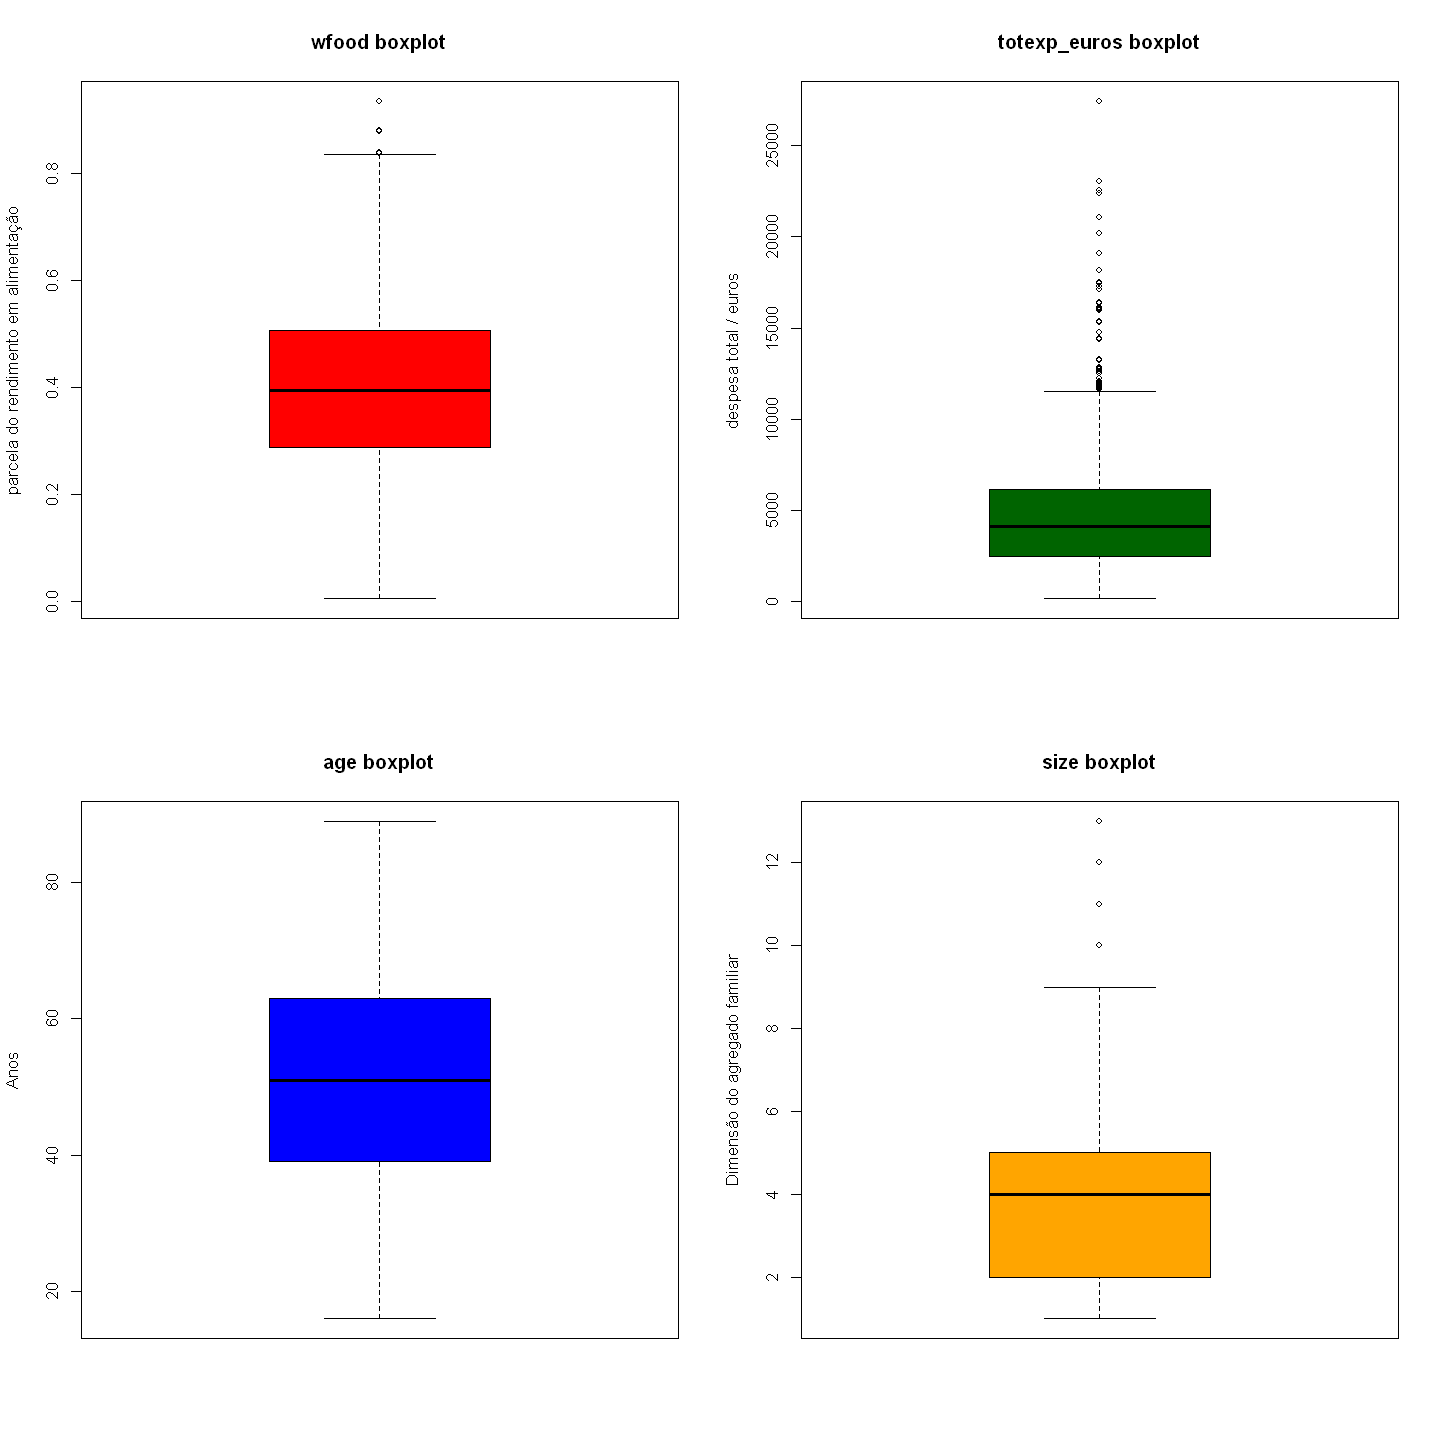

In [47]:
#Agregar gráficos num conjunto de 2 por 2 na visualização
par(mfrow=c(2,2))
#ajustar a dimensão do plot
options(repr.plot.width=12, repr.plot.height=12)

#Boxplot da variáveis não categóricas
boxplot(cleaned_sample$wfood, main="wfood boxplot", col="red", ylab="parcela do rendimento em alimentação")
boxplot(cleaned_sample$totexp_euros, main="totexp_euros boxplot", col="darkgreen", ylab="despesa total / euros")
boxplot(cleaned_sample$age, main="age boxplot", col="blue", ylab="Anos")
boxplot(cleaned_sample$size, main="size boxplot", col="orange", ylab="Dimensão do agregado familiar")

### Observações:
- Podemos verificar que a variável age não tem outliers;
- As restantes variáveis têm apenas outliers superiores;
- A variável totexp_euros apresenta um elevado número de outliers, alguns dos quais bastante distantes do máximo.

,wfood,age,size,town,sex_bin,totexp_euros
wfood,1.00000000,0.2110379,0.02218361,-0.18016264,-0.08434435,-0.5336570
age,0.21103785,1.0000000,-0.37006638,-0.15411108,-0.23601502,-0.2665790
size,0.02218361,-0.3700664,1.00000000,0.05415134,0.35996228,0.3319557
town,-0.18016264,-0.1541111,0.05415134,1.00000000,-0.01004440,0.2056913
sex_bin,-0.08434435,-0.2360150,0.35996228,-0.01004440,1.00000000,0.2519642
totexp_euros,-0.53365698,-0.2665790,0.33195567,0.20569130,0.25196423,1.0000000


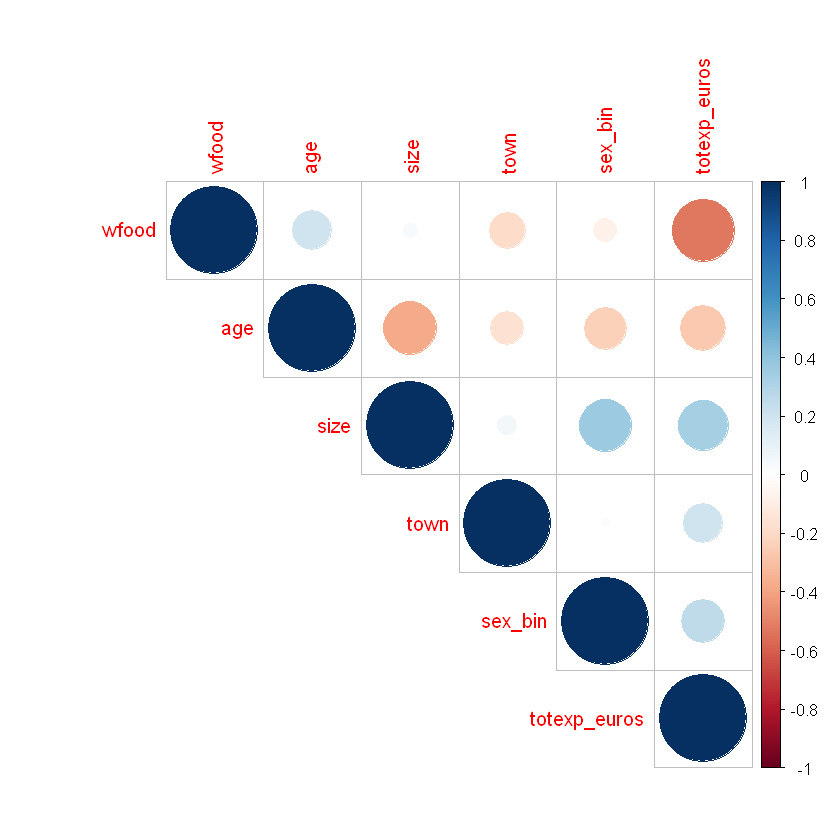

In [48]:
# Ajustar o modo gráfico para um conjunto de um por um para a visualização
par(mfrow=c(1,1)) 
options(repr.plot.width=7, repr.plot.height=7)

# Avaliar a correlação entre as variáveis excluíndo o id das linhas
cor(cleaned_sample[-c(1)])

# Matriz superior de correlação em modo gráfico
corrplot(cor(sample[c(2,4,5,6,8,9)]), type='upper')

### Observações:
- A feature totexp_euros tem uma correlação moderada negativa com a target; 
- Não existem correlações muito elevadas entre as variáveis dependentes, o que é importante para o nossa previsão.

## Visualização dos dados (Scatter Plots)

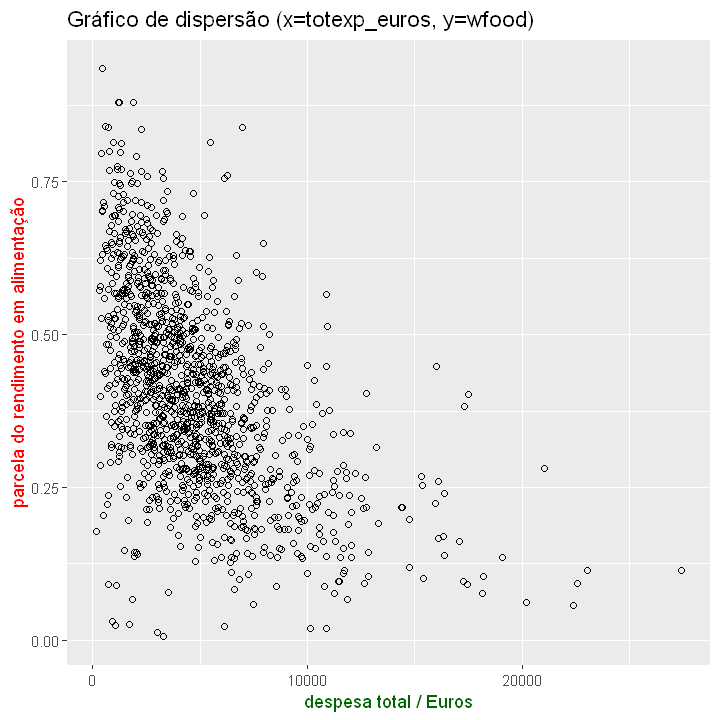

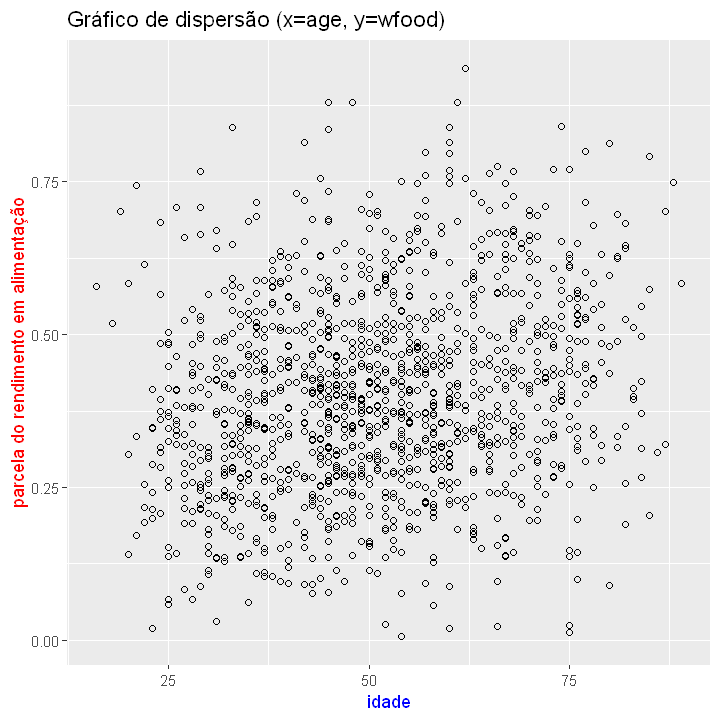

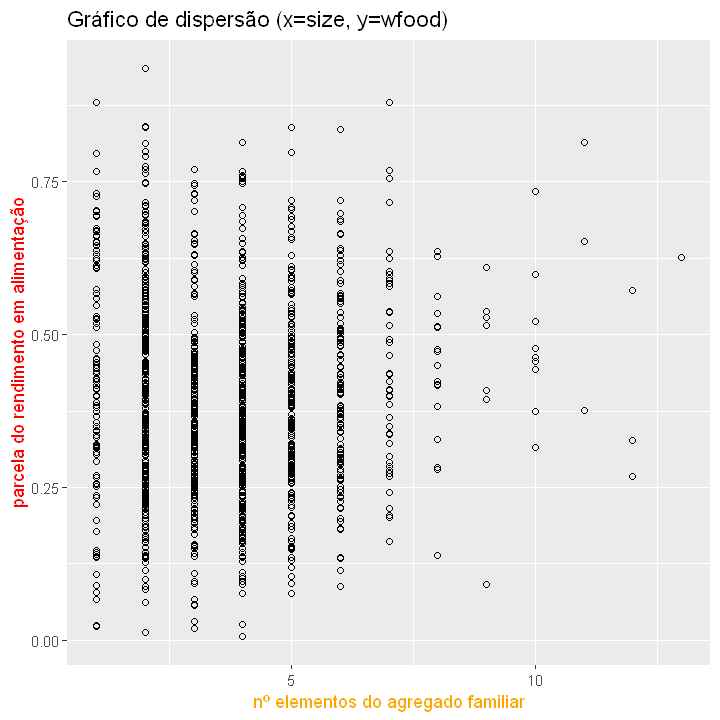

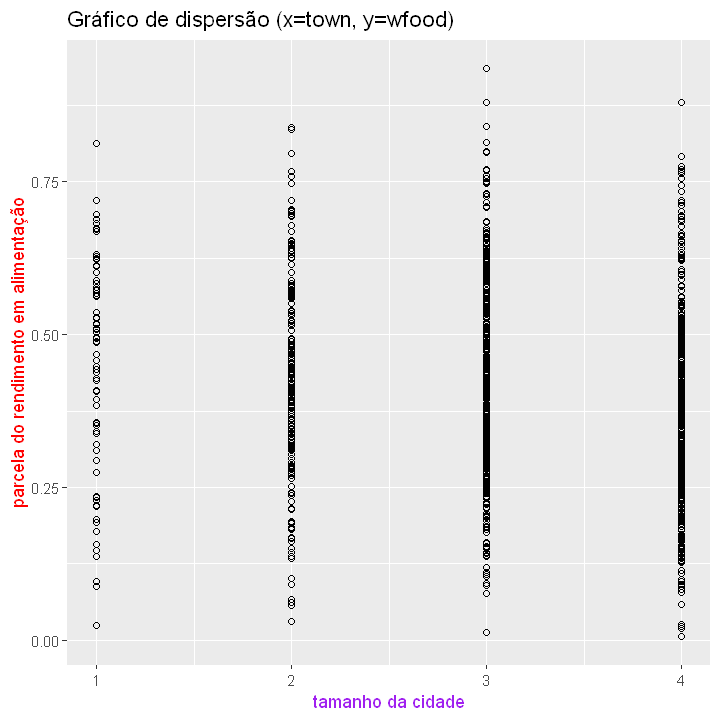

In [49]:
# Ajustar o modo gráfico
options(repr.plot.width=6, repr.plot.height=6)

# Elaboração dos scatter plots da target em função das features
  ggplot(cleaned_sample, aes(x=totexp_euros, y=wfood)) +
    geom_point(shape=1) +
    theme(axis.title.x = element_text(colour = "darkgreen"),
          axis.title.y = element_text(colour = "red"))+
    ggtitle("Gráfico de dispersão (x=totexp_euros, y=wfood)")+
    labs(y="parcela do rendimento em alimentação", x = "despesa total / Euros")
  
  ggplot(cleaned_sample, aes(x=age, y=wfood)) +
    geom_point(shape=1) + 
    theme(axis.title.x = element_text(colour = "blue"),
          axis.title.y = element_text(colour = "red"))+
    ggtitle("Gráfico de dispersão (x=age, y=wfood)")+
    labs(y="parcela do rendimento em alimentação", x = "idade")

 ggplot(cleaned_sample, aes(x=size, y=wfood)) +
    geom_point(shape=1) + 
    theme(axis.title.x = element_text(colour = "orange"),
          axis.title.y = element_text(colour = "red"))+
    ggtitle("Gráfico de dispersão (x=size, y=wfood)")+
    labs(y="parcela do rendimento em alimentação", x = "nº elementos do agregado familiar")
  
  ggplot(cleaned_sample, aes(x=town, y=wfood)) +
    geom_point(shape=1) + 
    theme(axis.title.x = element_text(colour = "purple"),
          axis.title.y = element_text(colour = "red"))+
    ggtitle("Gráfico de dispersão (x=town, y=wfood)")+
    labs(y="parcela do rendimento em alimentação", x = "tamanho da cidade")



### Ao visualizar os gráficos podemos concluir, que: 
- Além da relação entre a variável wfood e a totexp_euros não existe nenhuma outra relação demarcada;
- Os dois últimos gráficos são de difícil leitura por serem de variáveis categóricas.


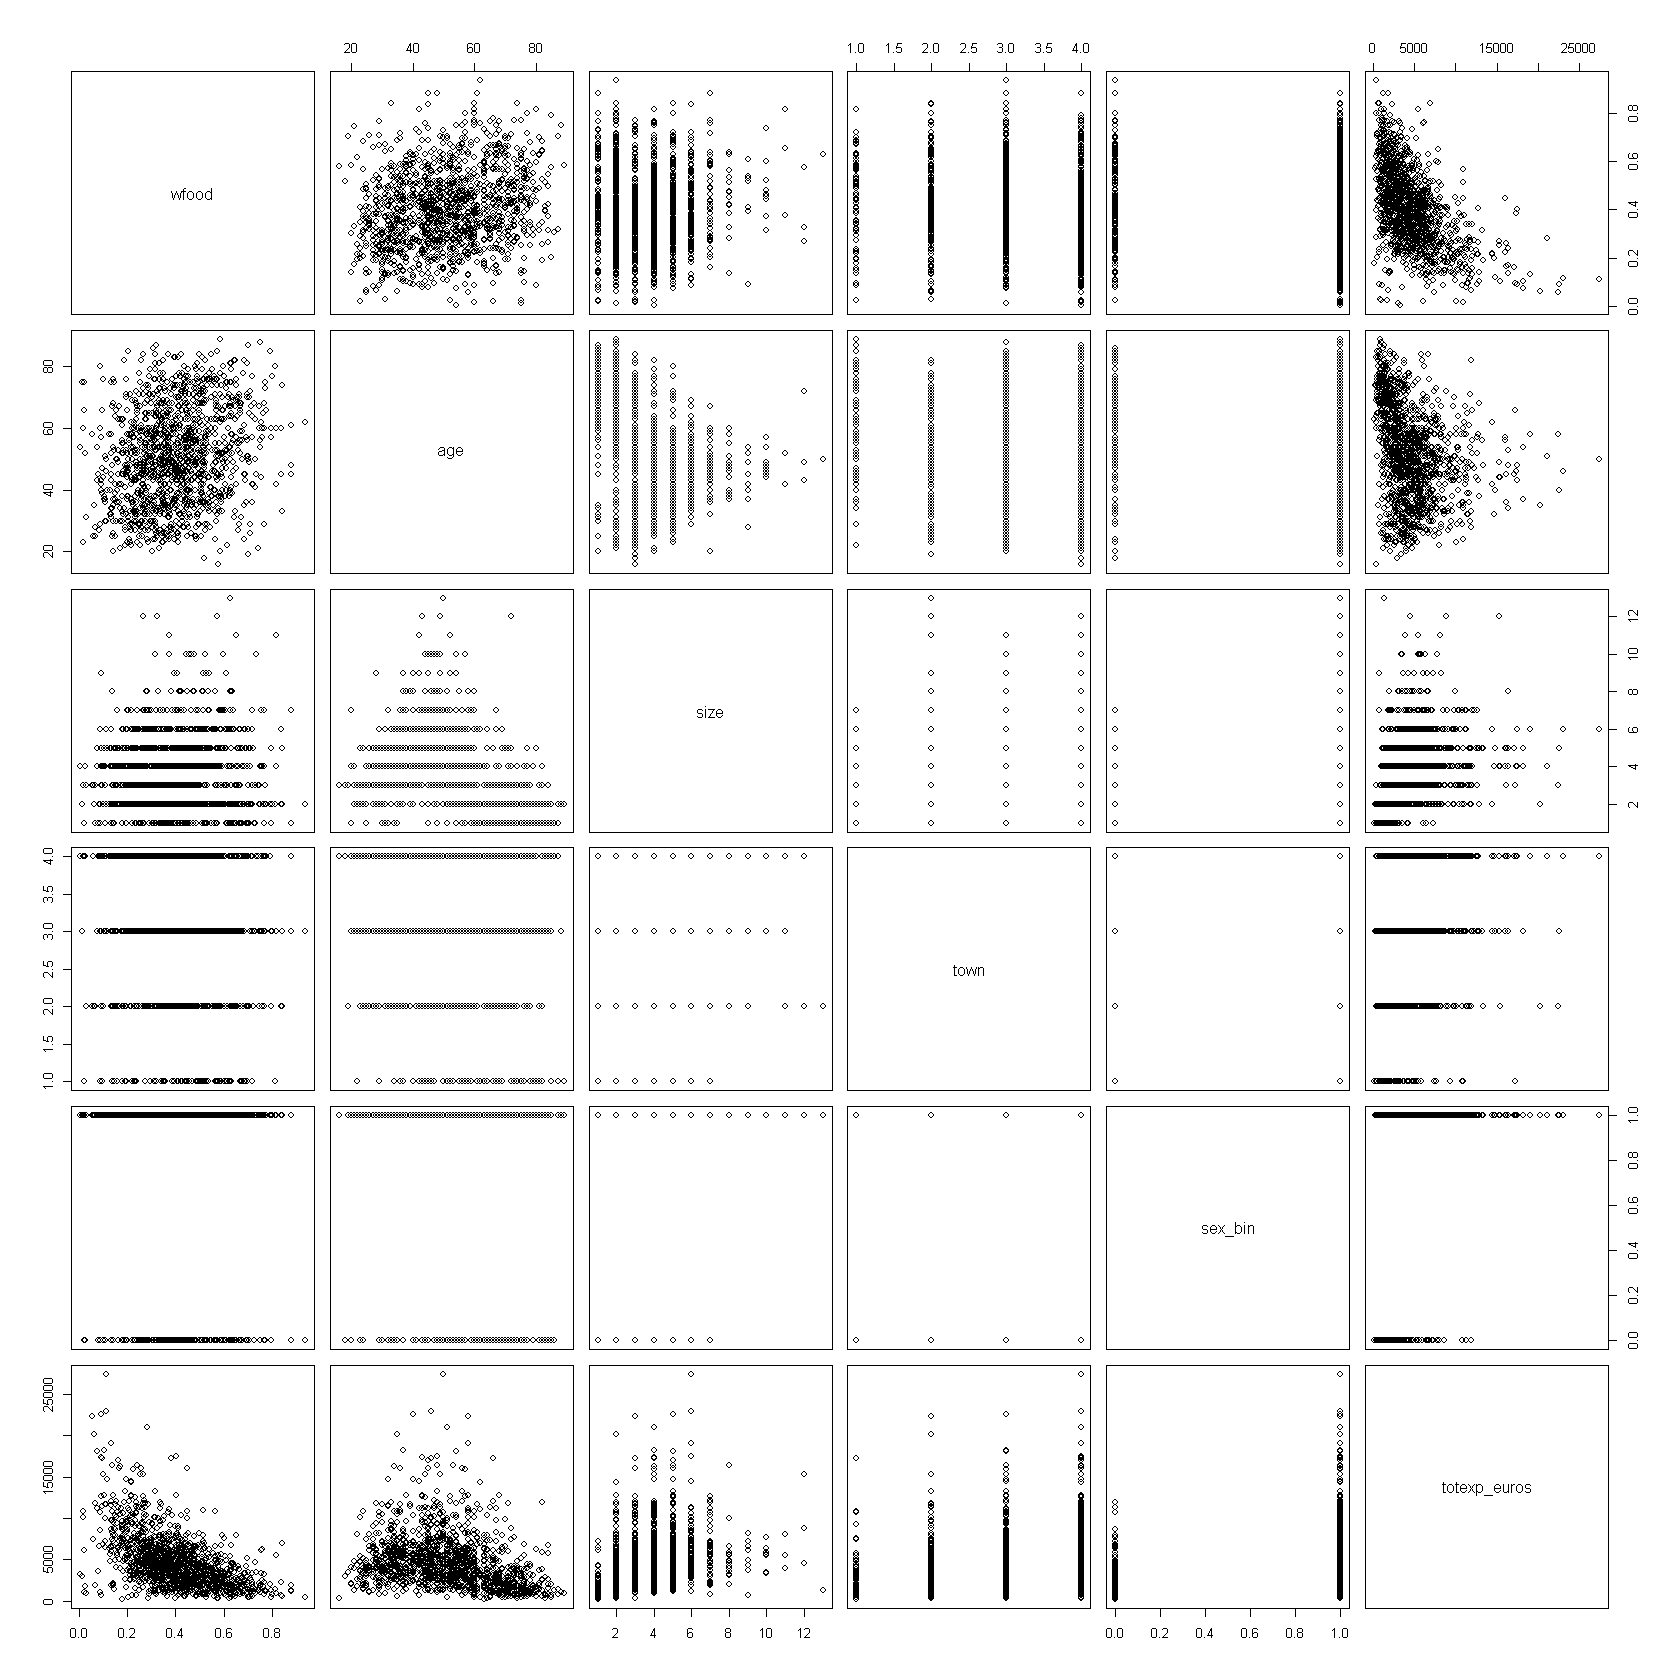

In [50]:
# Ajuste do modo gráfico
options(repr.plot.width=14, repr.plot.height=14)

# Gráficos com o objetivo de visulizar as correlações entre as variáveis
pairs(cleaned_sample[-c(1)])

## 4. Modelos de regressão línear.

### Nesta secção vamos fazer vários teste para encontrar o modelo que melhor prevê a variável target.

In [51]:
# Modelo 0 - fit0

# Vamos criar o primeiro modelo, com todas as variáveis (wfood, size, age, town, totexp_euros e sex_bin)
info = cleaned_sample[-c(1)]
fit0 = lm(wfood ~., data=info)

In [52]:
summary(fit0)


Call:
lm(formula = wfood ~ ., data = info)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54168 -0.08415 -0.00890  0.07547  0.48637 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.983e-01  2.533e-02  15.722  < 2e-16 ***
age           1.578e-03  2.602e-04   6.065 1.73e-09 ***
size          2.333e-02  2.224e-03  10.491  < 2e-16 ***
town         -9.961e-03  4.249e-03  -2.344   0.0192 *  
sex_bin      -1.535e-03  1.190e-02  -0.129   0.8973    
totexp_euros -2.764e-05  1.195e-06 -23.134  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1293 on 1291 degrees of freedom
Multiple R-squared:  0.3529,	Adjusted R-squared:  0.3504 
F-statistic: 140.8 on 5 and 1291 DF,  p-value: < 2.2e-16


### Observação:
- A variável sex_bin tem o p-value=0.8973, o que é um valor muito elevado. Colcluímos que a variável sex_bin não é estatísticamente significante. 

In [53]:
# Escolha do modelo 1 de forma automática através da função ols_step_both:
ols_step_both_p(fit0)   # baseado no p-value
ols_step_both_aic(fit0) # baseado no AIC


                                 Stepwise Selection Summary                                  
--------------------------------------------------------------------------------------------
                         Added/                   Adj.                                          
Step      Variable      Removed     R-Square    R-Square      C(p)         AIC         RMSE     
--------------------------------------------------------------------------------------------
   1    totexp_euros    addition       0.285       0.284    133.8860    -1495.4237    0.1357    
   2        size        addition       0.329       0.328     46.7970    -1577.0414    0.1315    
   3        age         addition       0.350       0.349      7.4970    -1615.7131    0.1295    
   4        town        addition       0.353       0.351      4.0170    -1619.2072    0.1293    
--------------------------------------------------------------------------------------------



                                 Stepwise Summary                                  
---------------------------------------------------------------------------------
Variable         Method        AIC        RSS      Sum Sq     R-Sq      Adj. R-Sq 
---------------------------------------------------------------------------------
totexp_euros    addition    -1495.424    23.863     9.502    0.28479      0.28424 
size            addition    -1577.041    22.373    10.992    0.32944      0.32841 
age             addition    -1615.713    21.682    11.683    0.35015      0.34864 
town            addition    -1619.207    21.591    11.774    0.35289      0.35089 
---------------------------------------------------------------------------------


### Observações:
- Ambas as funções devolvem a mesma combinação de variáveis para o modelo.
- Como já era de esperar as funções removeram a variável sex_bin.

In [54]:
# Modelo 1 - fit1

# Criação de um dataframe baseado no cleaned_sample removendo a variável sex_bin
info1 = cleaned_sample[-c(1,6)]

# Modelo 1
fit1 = lm(wfood ~., data=info1)
summary(fit1)

AIC(fit1)


Call:
lm(formula = wfood ~ ., data = info1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54149 -0.08443 -0.00912  0.07634  0.48643 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.970e-01  2.335e-02  17.002  < 2e-16 ***
age           1.582e-03  2.587e-04   6.115 1.28e-09 ***
size          2.326e-02  2.146e-03  10.836  < 2e-16 ***
town         -9.919e-03  4.235e-03  -2.342   0.0193 *  
totexp_euros -2.767e-05  1.182e-06 -23.410  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1293 on 1292 degrees of freedom
Multiple R-squared:  0.3529,	Adjusted R-squared:  0.3509 
F-statistic: 176.1 on 4 and 1292 DF,  p-value: < 2.2e-16


[1] -1619.207

### Observações do modelo fit1:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.3529;
- O AIC é de -1619.21.

### Verificação dos pressupostos dos resíduos do modelo fit1

In [55]:
# Verificação da média nula
mean(fit1$residuals) 

# Teste de Breusch-Pagan 
bptest(fit1)
        
# Teste de Breusch-Godfrey 
bgtest(fit1) 

# Teste de Jarque-Bera 
jarque.bera.test(fit1$residuals)

[1] 5.215529e-18


	studentized Breusch-Pagan test

data:  fit1
BP = 24.828, df = 4, p-value = 5.449e-05



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit1
LM test = 12.245, df = 1, p-value = 0.0004666



	Jarque Bera Test

data:  fit1$residuals
X-squared = 52.188, df = 2, p-value = 4.652e-12


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 5.449e-05 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.0004666 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 4.652e-12 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado. Vamos visualizar o que pode estar a acontecer.

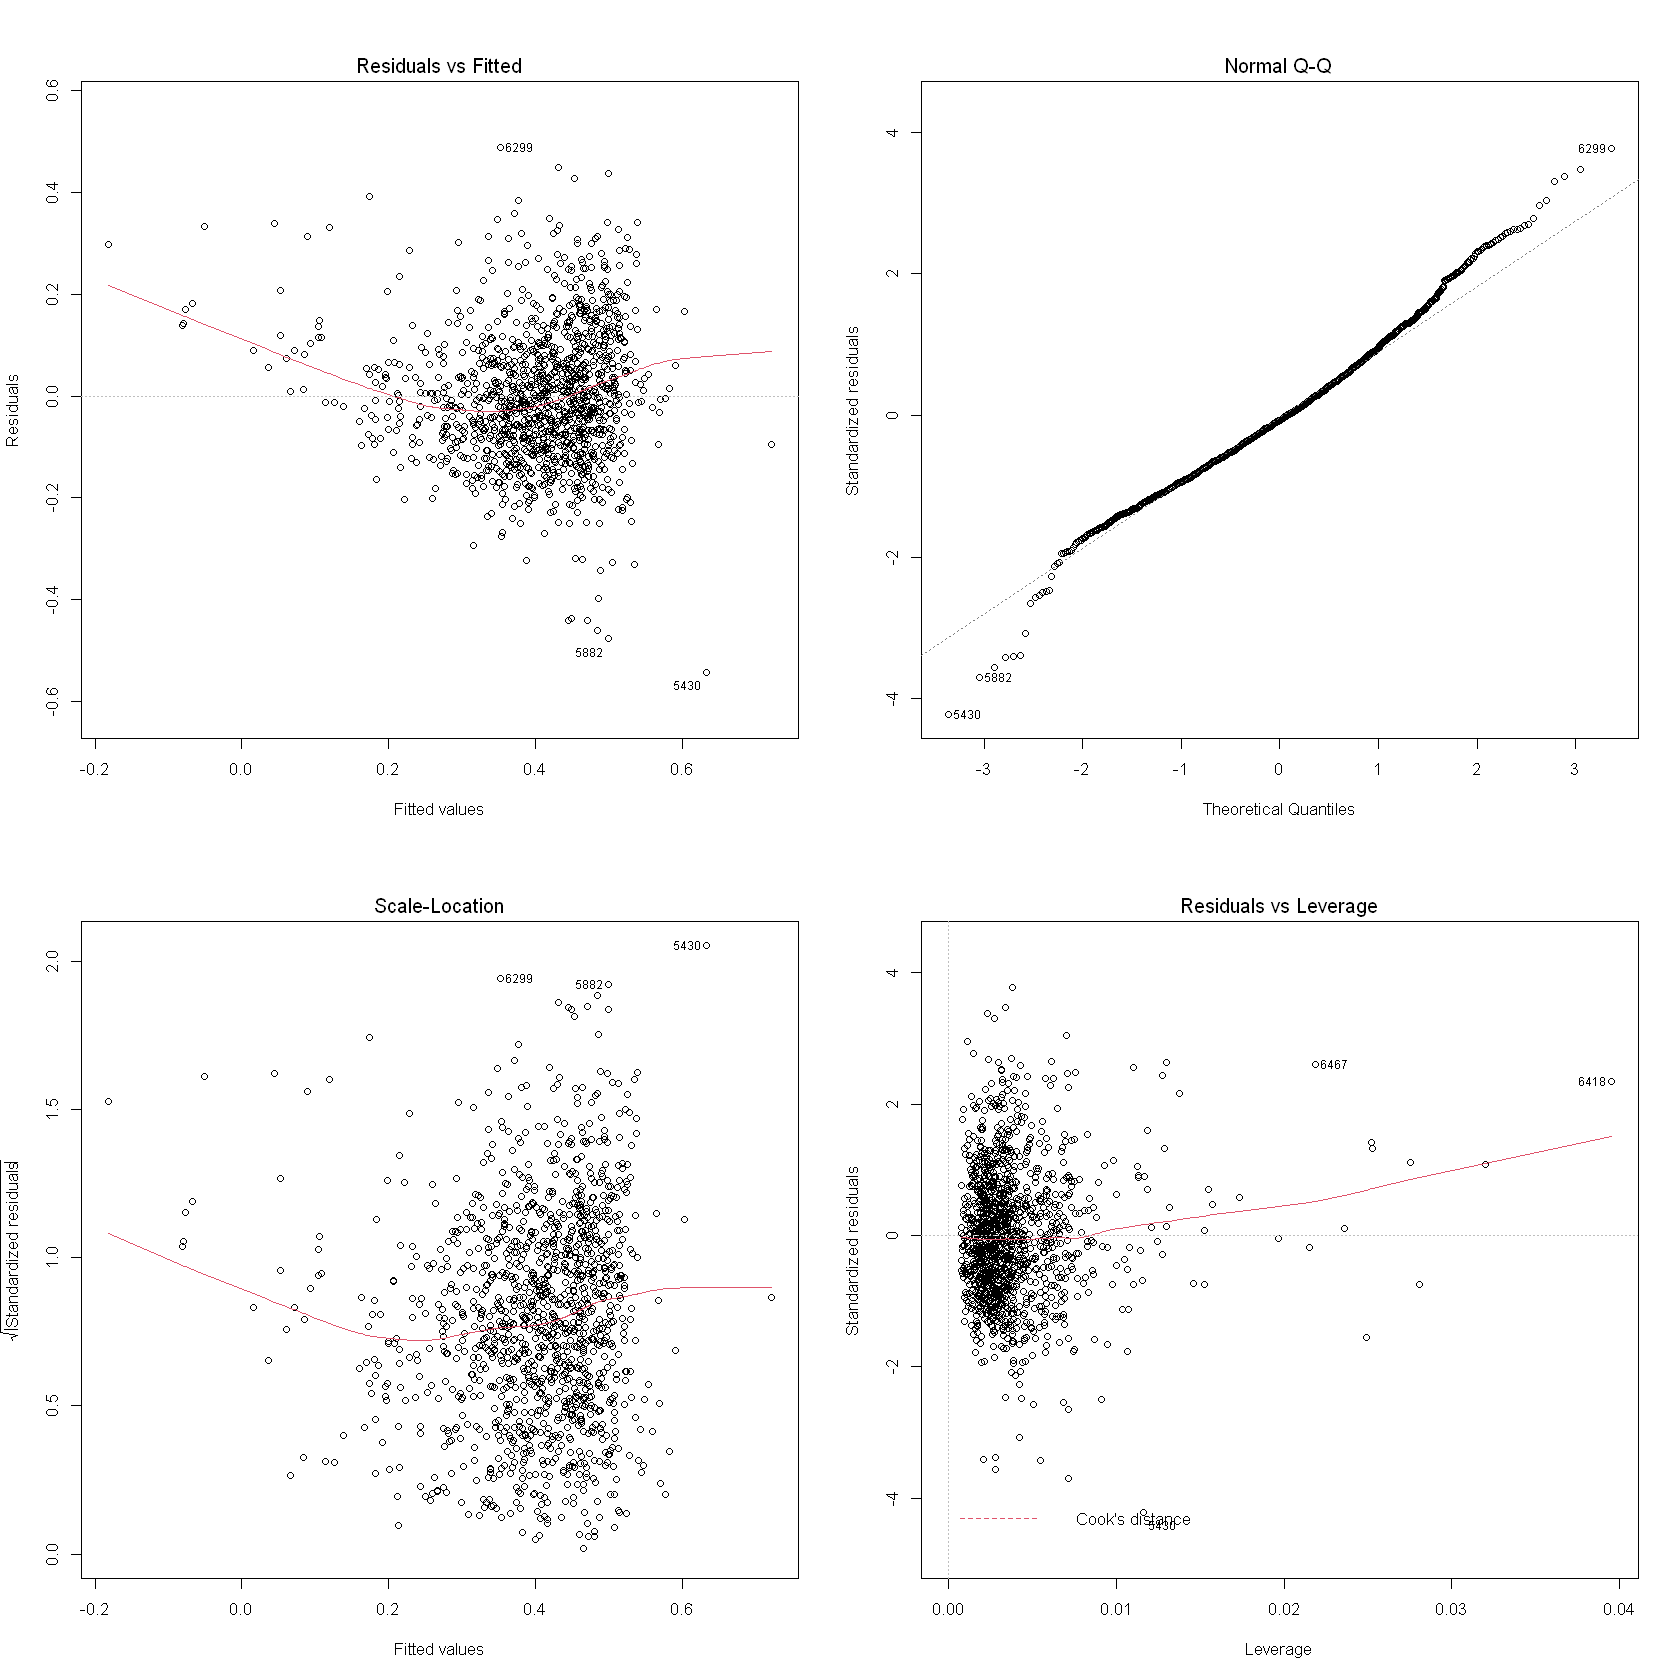

In [56]:
# Ajuste do modo gráfico
par(mfrow=c(2,2)) 

# plot dos gráficos relativos aos resíduos do modelo fit1
plot(fit1)


#### Através da observação do gráfico concluímos que existem outliers que estão a influênciar o modelo. Vamos prosseguir a um estudo para eliminar essas linhas.

## 5. Tratamento de outliers

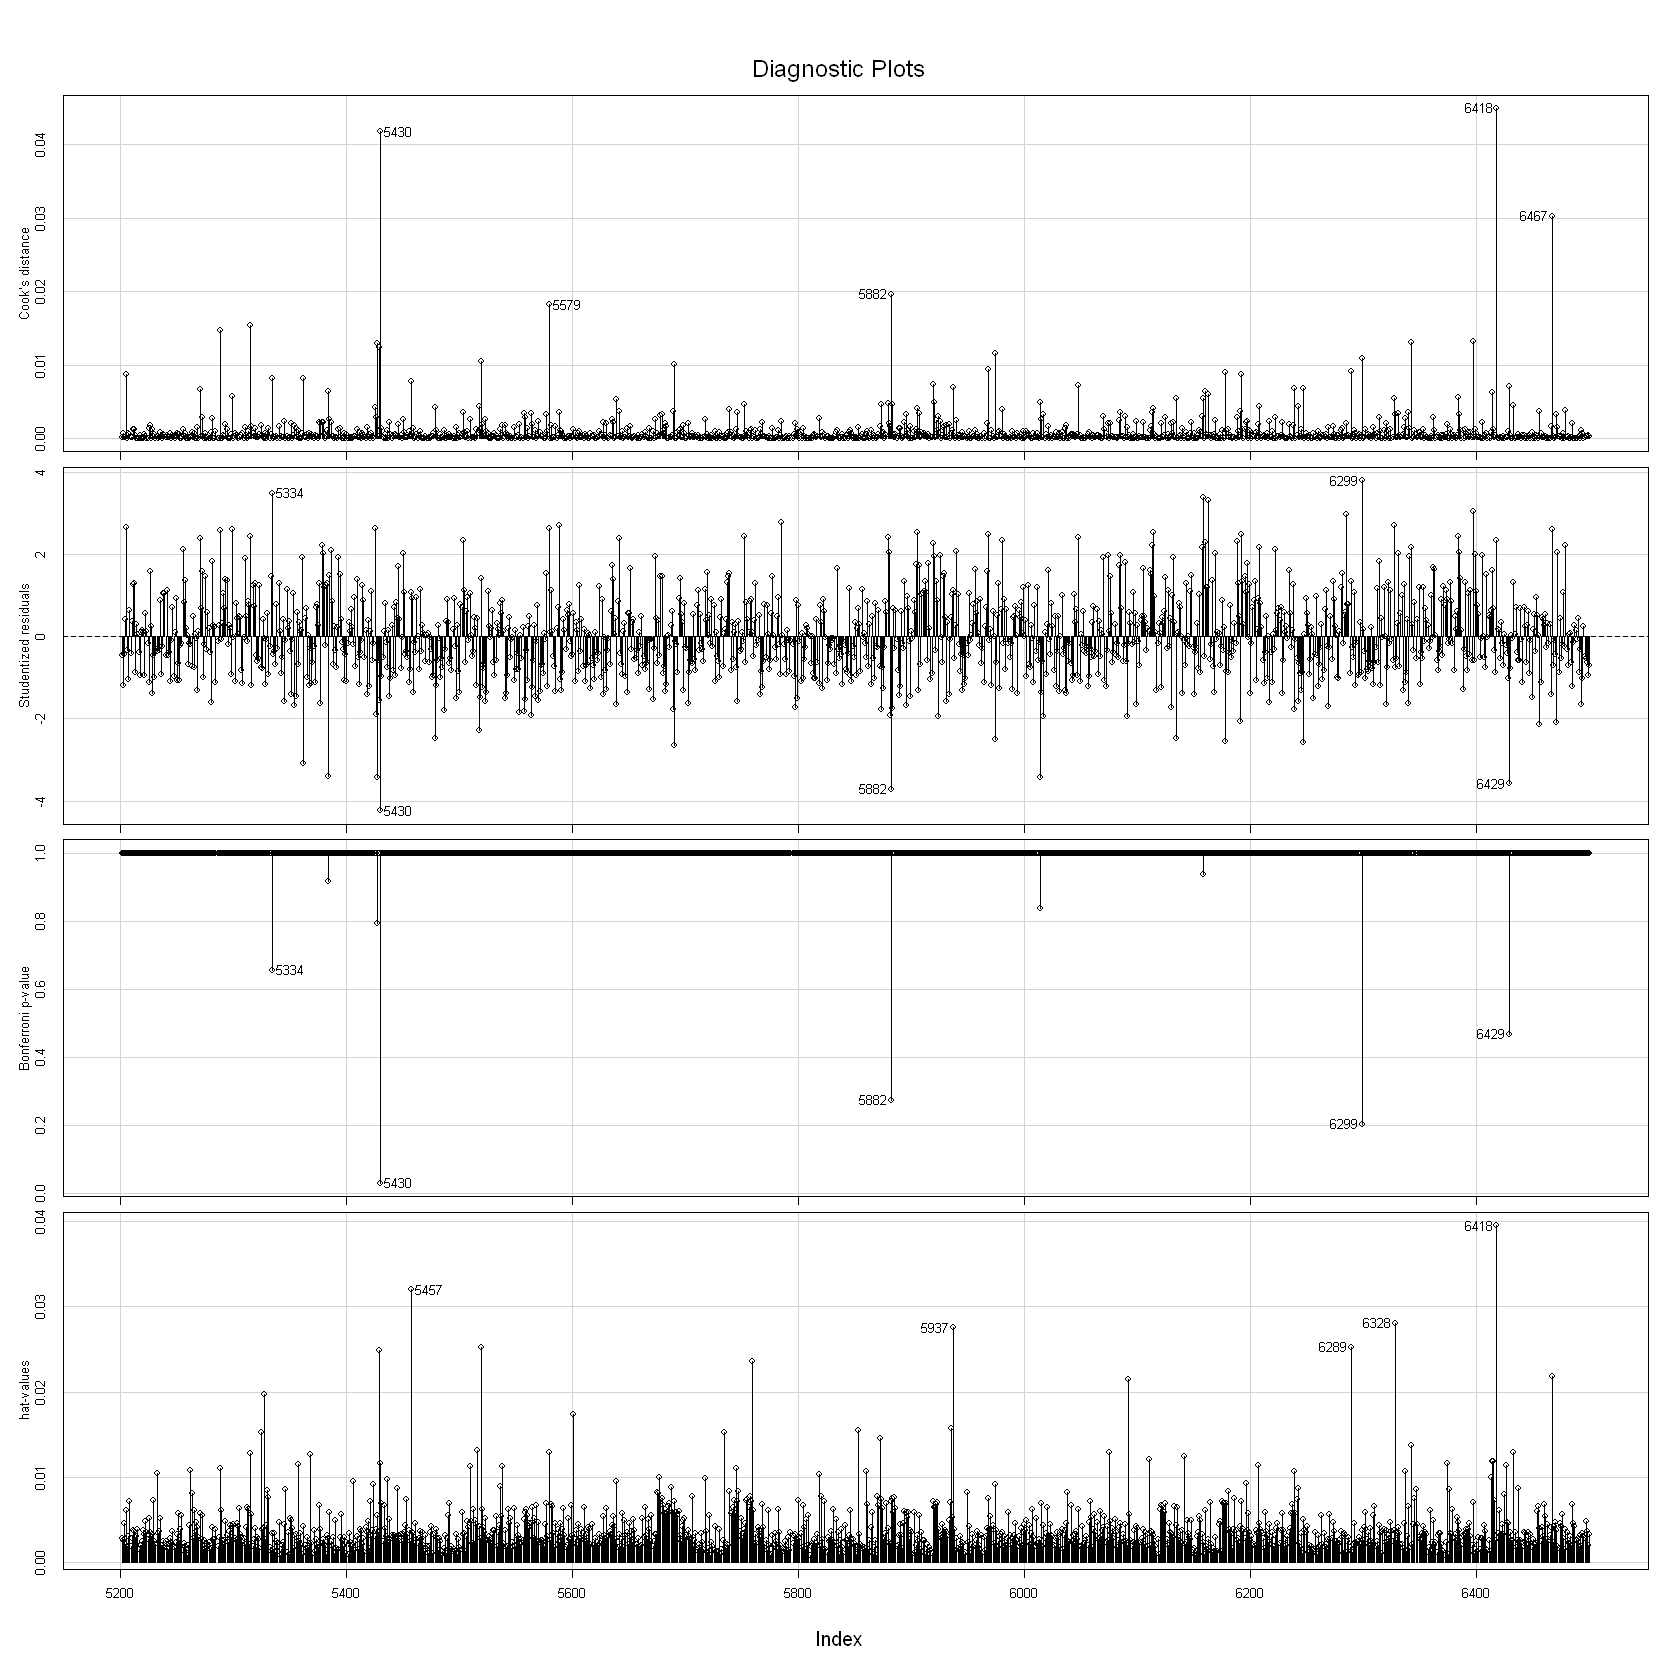

In [57]:
# Determinação dos valores influenciadores do modelo fit1
influenceIndexPlot(fit1, id=list(n=5))

### A partir da observação do gráfico concluímos que os valores influenciadores são:  

- 5430 - Tem um valor muito baixo na variável wfood = 0.09171846;
- 5882 - Tem um valor muito baixo na variável wfood = 0.02405806;
- 6418 - Tem um valor da variável totexp_euros muito elevado =  4568636.

In [59]:
# Cálculo da distância de Cook
cooks_distance <- cooks.distance(fit1)
    
# Determinar os valores que mais influênciam o modelo
influential <- as.numeric(names(cooks_distance)[(cooks_distance > 4 * mean(cooks_distance))])
                       
# dataframe com os valores influênciadores                       
influenciadores = BudgetFood[influential,]
    
for (i in c(0:length(influenciadores[,1]))) {
    influenciadores[i,3] = influenciadores[i,3] * 6 / 1000
}

influenciadores[influenciadores$X %in% c(5384, 5427, 5430, 5882, 6014, 6018, 6299, 6418, 6429),]

,X,wfood,totexp,age,size,town,sex
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>
5384,5384,0.012396694,3020.160,75,2,3,man
5427,5427,0.029896117,907.944,31,3,2,man
5430,5430,0.091718461,714.360,42,9,2,man
5882,5882,0.024058063,1037.490,75,1,1,woman
6014,6014,0.005233255,3279.030,54,4,4,man
6299,6299,0.839429301,6964.932,33,5,2,man
6418,6418,0.113819530,27411.816,50,6,4,man
6429,6429,0.025331519,1724.334,52,4,4,woman


In [60]:
# Vamos analisar quais destes valores são observações estranhas

# Criação da variável de gastos em alimentação percapita para distinguir mais fácilmente observações 
# fora do comum
percapita = c()
    
for (i in c(0:length(influenciadores[,1]))) {
    percapita[i] = influenciadores[i,2] * influenciadores[i,3] / influenciadores[i,5]
}

# Adicionar coluna ao DataFrame dos influênciadores
influenciadores["percapita"] = percapita

head(influenciadores)


,X,wfood,totexp,age,size,town,sex,percapita
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
5205,5205,0.8798746,1899.216,45,7,4,man,238.7246
5270,5270,0.6710850,2763.012,31,1,3,man,1854.2160
5288,5288,0.4485680,16021.224,56,5,4,man,1437.3216
5299,5299,0.7668900,2285.616,29,4,4,man,438.2040
5315,5315,0.4019605,17493.120,48,6,4,man,1171.9240
5334,5334,0.8801309,1238.952,48,1,3,woman,1090.4400


### Ao analisar cada uma das linhas decidímos: 
- Eliminar as observações- 5384, 5427, 5430, 5882, 6014, 6018, 6299, 6418, 6429;
- No relatório vamos apontar as razões de termos escolhido estas linhas.

In [61]:
# Eliminar as linhas através de um operador oposto ao in:
`%notin%` <- Negate(`%in%`)
final_sample = cleaned_sample[cleaned_sample$X %notin% c(5384, 5427, 5430, 5882, 6014, 6018, 6299, 6418, 6429),]

## 6. Modelos (após a remoção dos outliers)

In [62]:
# Modelo2 fit2 semelhante ao modelo fit1 com a remoção dos outliers

info2 = final_sample[-c(1,6)]
fit2 = lm(wfood ~., data=info2)
summary(fit2)

AIC(fit1, fit2)
vif(fit2)


Call:
lm(formula = wfood ~ ., data = info2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40248 -0.08446 -0.00907  0.07375  0.44374 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.018e-01  2.265e-02  17.740  < 2e-16 ***
age           1.599e-03  2.504e-04   6.387 2.36e-10 ***
size          2.393e-02  2.080e-03  11.505  < 2e-16 ***
town         -1.007e-02  4.106e-03  -2.453   0.0143 *  
totexp_euros -2.895e-05  1.165e-06 -24.845  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1246 on 1283 degrees of freedom
Multiple R-squared:  0.382,	Adjusted R-squared:  0.3801 
F-statistic: 198.3 on 4 and 1283 DF,  p-value: < 2.2e-16


Warning message in AIC.default(fit1, fit2):
"models are not all fitted to the same number of observations"


,df,AIC
,<dbl>,<dbl>
fit1,6,-1619.207
fit2,6,-1701.849


age         size         town totexp_euros 
    1.207997     1.245800     1.057721     1.197017

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.382;
-  Ao retirar os outliers o AIC do modelo melhora, no caso do fit2 é de -1701.849 que é inferior ao do fit1 (-1619.202) .

In [63]:
# Elaborar a regressão linear robusta (rlm) para observar se há ainda valores extremos a afetar o modelo
fit2_robust = rlm(formula=wfood ~., data=info2)
summary(fit2_robust)


Call: rlm(formula = wfood ~ ., data = info2)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.398757 -0.078328 -0.003753  0.078573  0.450677 

Coefficients:
             Value    Std. Error t value 
(Intercept)    0.3937   0.0225    17.4704
age            0.0017   0.0002     6.8173
size           0.0249   0.0021    12.0420
town          -0.0115   0.0041    -2.8041
totexp_euros   0.0000   0.0000   -25.2728

Residual standard error: 0.1162 on 1283 degrees of freedom

### Observações:
 Os parâmetros do modelo fit2 em comparação com fit2_robust não apresentam alterações notórias. Esta observação demonstra a inexistência de valores a afetar o modelo de modo acentuado.

### Verificação dos pressupostos dos resíduos do modelo fit2

In [64]:
# Verificação da média nula
mean(fit2$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit2)
   
# Teste de Breusch-Godfrey 
bgtest(fit2) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit2$residuals)


[1] -4.276633e-18


	studentized Breusch-Pagan test

data:  fit2
BP = 32.411, df = 4, p-value = 1.577e-06



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit2
LM test = 9.1194, df = 1, p-value = 0.002529



	Jarque Bera Test

data:  fit2$residuals
X-squared = 42.195, df = 2, p-value = 6.878e-10


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 1.577e-06 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.002529 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 6.878e-10 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado. Vamos visualizar o que pode estar a acontecer.

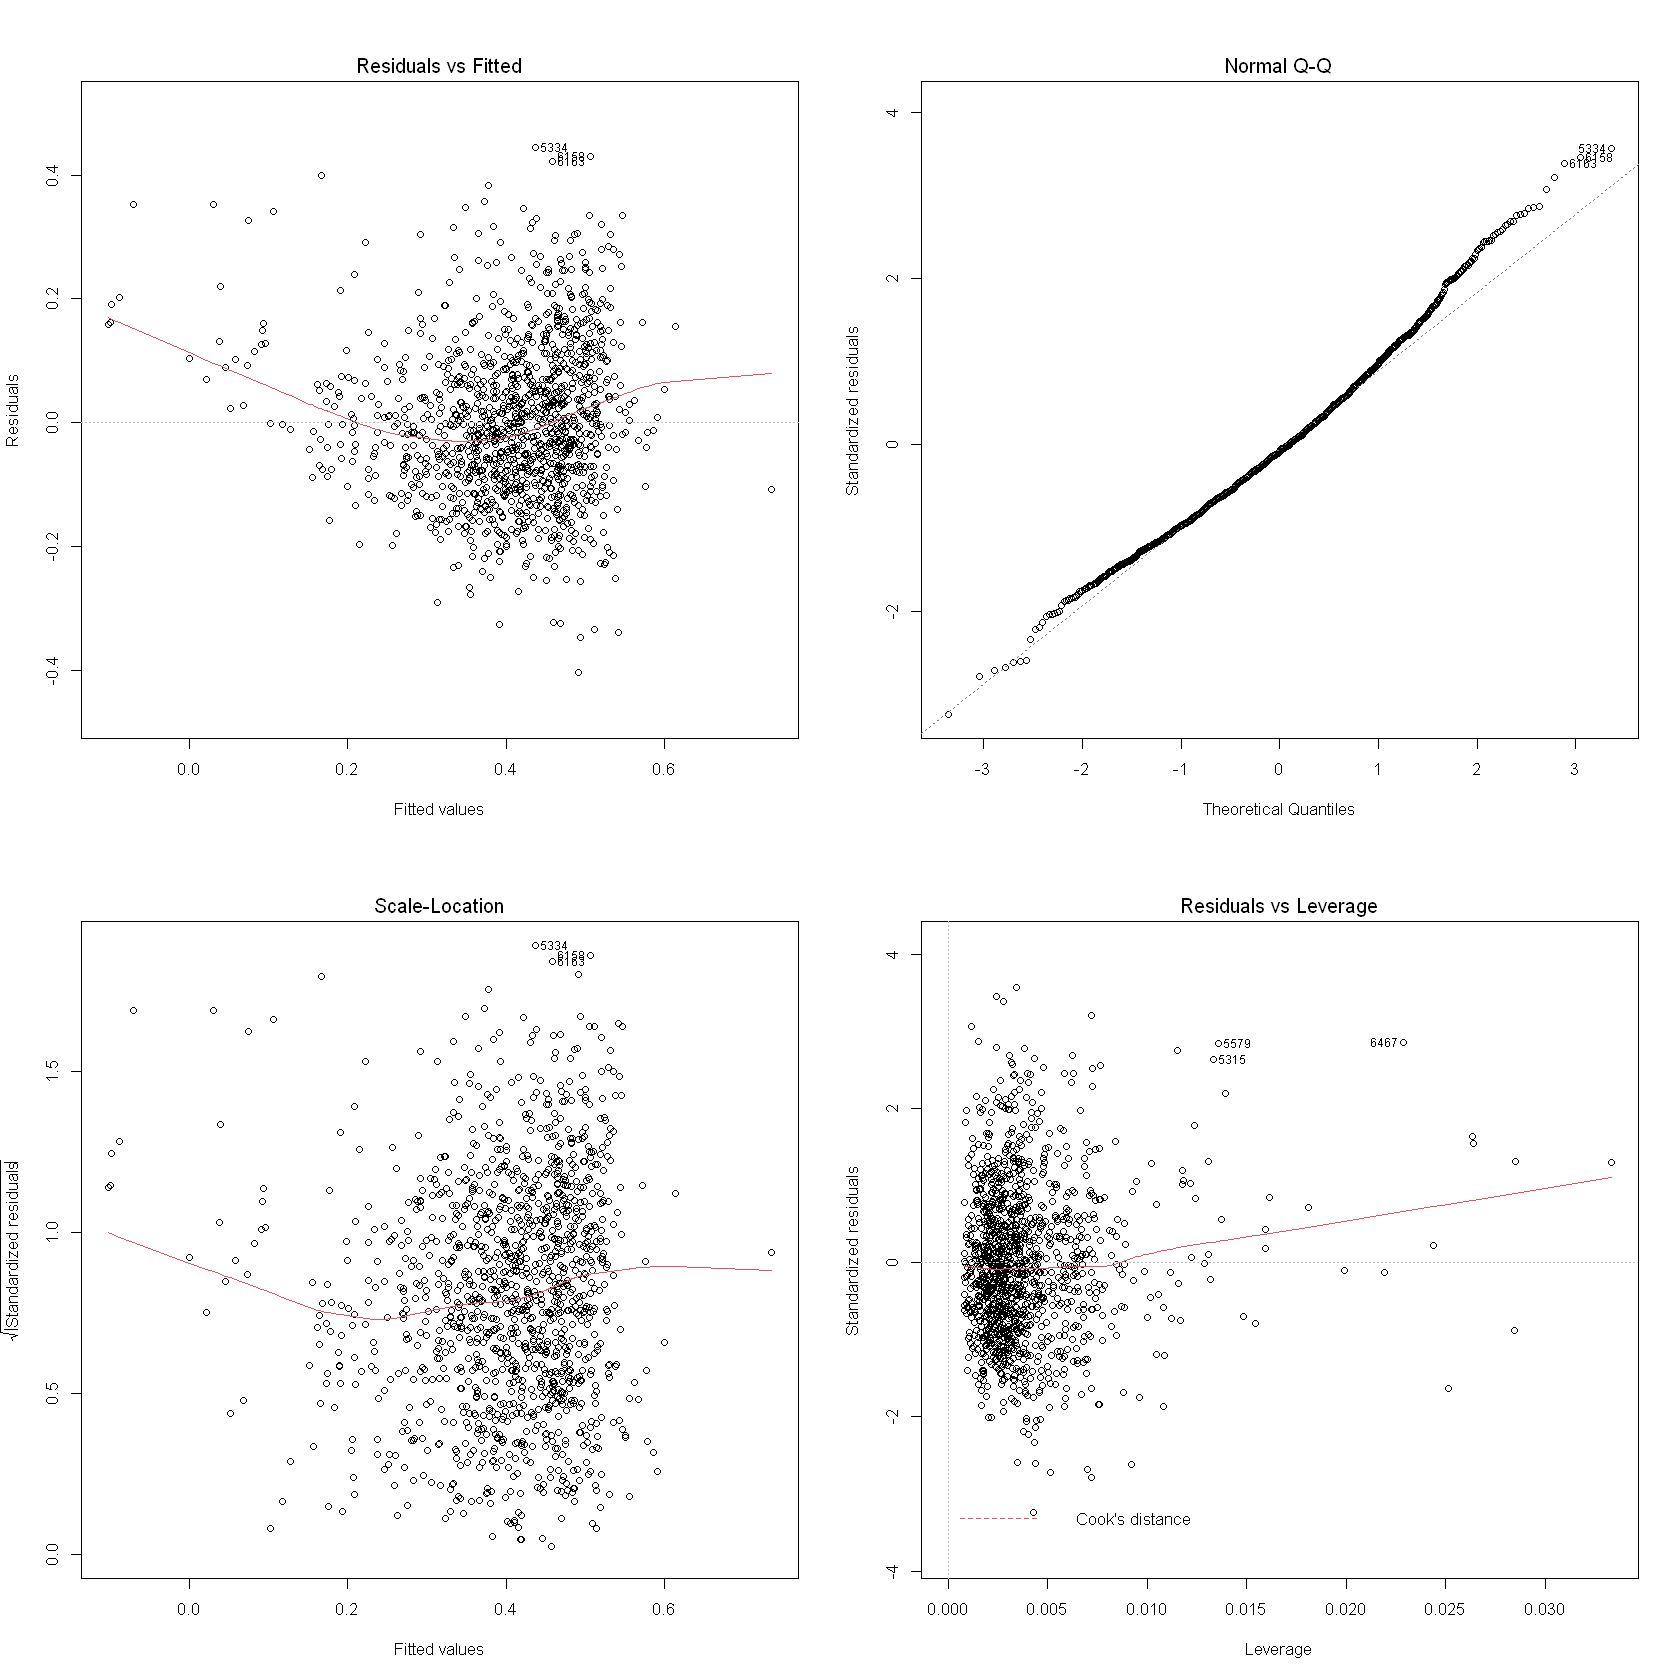

In [65]:
# Visualização dos gráficos relativos aos pressupostos do modelo fit2
par(mfrow=c(2,2)) 
plot(fit2)

### Modelo 3 (fit 3):
- Vamos aplicar uma raíz quadrada na variável target para ajustar o modelo de regressão linear com auxílio de uma função

In [66]:
# Modelo 3 fit3
fit3 = lm(sqrt(wfood)~., data=info2)
summary(fit3)

AIC(fit2, fit3)

# Observar a multicolinearidade entre variáveis
vif(fit3)


Call:
lm(formula = sqrt(wfood) ~ ., data = info2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39543 -0.06269  0.00068  0.06502  0.33414 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.152e-01  1.806e-02  34.054  < 2e-16 ***
age           1.311e-03  1.997e-04   6.563 7.61e-11 ***
size          2.138e-02  1.659e-03  12.888  < 2e-16 ***
town         -6.663e-03  3.275e-03  -2.035   0.0421 *  
totexp_euros -2.506e-05  9.294e-07 -26.969  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09941 on 1283 degrees of freedom
Multiple R-squared:  0.4165,	Adjusted R-squared:  0.4147 
F-statistic:   229 on 4 and 1283 DF,  p-value: < 2.2e-16


,df,AIC
,<dbl>,<dbl>
fit2,6,-1701.849
fit3,6,-2284.434


age         size         town totexp_euros 
    1.207997     1.245800     1.057721     1.197017

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.4165 aumentando em relação ao modelo anterior;
- O AIC é de -2284.434 com um aumento espantoso em relação ao modelo anterior o que indica uma vantagem ao aplicar a transformação por uma função no target.

### Teste para os pressupostos dos resíduos do modelo fit3:

In [67]:
# Verificação da média nula
mean(fit3$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit3)
   
# Teste de Breusch-Godfrey 
bgtest(fit3) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit3$residuals)

[1] -3.326388e-18


	studentized Breusch-Pagan test

data:  fit3
BP = 40.08, df = 4, p-value = 4.167e-08



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit3
LM test = 8.241, df = 1, p-value = 0.004096



	Jarque Bera Test

data:  fit3$residuals
X-squared = 22.343, df = 2, p-value = 1.407e-05


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 4.167e-08 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.004096 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 1.407e-05 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado.

### Modelo 4:

- Vamos aplicar a variável sex_bin, desta vez em combinação com outra variável 

In [68]:
# Modelo 4
info3 = final_sample[-c(1)]
fit4 = lm(sqrt(wfood) ~ totexp_euros*sex_bin+size+age+town ,data=info3)
summary(fit4)

AIC(fit3, fit4)

# Observar a multicolinearidade entre variáveis
vif(fit4)


Call:
lm(formula = sqrt(wfood) ~ totexp_euros * sex_bin + size + age + 
    town, data = info3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39258 -0.06251  0.00102  0.06438  0.32882 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.492e-01  2.198e-02  29.535  < 2e-16 ***
totexp_euros         -3.739e-05  3.649e-06 -10.249  < 2e-16 ***
sex_bin              -3.456e-02  1.383e-02  -2.498 0.012609 *  
size                  2.151e-02  1.713e-03  12.558  < 2e-16 ***
age                   1.256e-03  2.007e-04   6.258 5.29e-10 ***
town                 -6.807e-03  3.272e-03  -2.080 0.037699 *  
totexp_euros:sex_bin  1.299e-05  3.724e-06   3.489 0.000501 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09902 on 1281 degrees of freedom
Multiple R-squared:  0.422,	Adjusted R-squared:  0.4193 
F-statistic: 155.9 on 6 and 1281 DF,  p-value: < 2.2e-16


,df,AIC
,<dbl>,<dbl>
fit3,6,-2284.434
fit4,8,-2292.646


totexp_euros              sex_bin                 size 
           18.594718             2.719651             1.338563 
                 age                 town totexp_euros:sex_bin 
            1.229364             1.064502            22.138721

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.422 aumentando em relação ao modelo anterior;
- O AIC é de -2292.646 com um aumento ligeiro em relação ao modelo anterior.

### Teste para os pressupostos dos resíduos do modelo fit4:

In [69]:
# Verificação da média nula
mean(fit4$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit4)
   
# Teste de Breusch-Godfrey 
bgtest(fit4) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit4$residuals)

[1] 5.153012e-19


	studentized Breusch-Pagan test

data:  fit4
BP = 40.444, df = 6, p-value = 3.725e-07



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit4
LM test = 8.1805, df = 1, p-value = 0.004234



	Jarque Bera Test

data:  fit4$residuals
X-squared = 22.003, df = 2, p-value = 1.668e-05


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 3.725e-07 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.004234 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 1.668e-05 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado.

### Modelo 5:
- Introdução de um polinómio de segundo grau para a variável size.

In [70]:
# Modelo 5
fit5=lm(sqrt(wfood)~totexp_euros*sex_bin+size+I(size^2)+age+town, data = info3)
summary(fit5)

AIC(fit3, fit4, fit5)
# Observar a multicolinearidade entre variáveis
vif(fit5)


Call:
lm(formula = sqrt(wfood) ~ totexp_euros * sex_bin + size + I(size^2) + 
    age + town, data = info3)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37713 -0.06163  0.00053  0.06360  0.33490 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.194e-01  2.380e-02  26.023  < 2e-16 ***
totexp_euros         -3.912e-05  3.676e-06 -10.644  < 2e-16 ***
sex_bin              -4.736e-02  1.435e-02  -3.299 0.000996 ***
size                  3.867e-02  5.638e-03   6.860 1.07e-11 ***
I(size^2)            -1.714e-03  5.366e-04  -3.195 0.001433 ** 
age                   1.431e-03  2.073e-04   6.901 8.11e-12 ***
town                 -6.899e-03  3.261e-03  -2.116 0.034564 *  
totexp_euros:sex_bin  1.440e-05  3.737e-06   3.854 0.000122 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09867 on 1280 degrees of freedom
Multiple R-squared:  0.4266,	Adjusted R-squared:  0.4234 
F-statisti

,df,AIC
,<dbl>,<dbl>
fit3,6,-2284.434
fit4,8,-2292.646
fit5,9,-2300.877


totexp_euros              sex_bin                 size 
           19.007100             2.949512            14.609480 
           I(size^2)                  age                 town 
           12.507440             1.321147             1.064584 
totexp_euros:sex_bin 
           22.451546

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.4266;
- O AIC é de -2300.877.

### Teste para os pressupostos dos resíduos do modelo fit5:

In [71]:
# Verificação da média nula
mean(fit5$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit5)
   
# Teste de Breusch-Godfrey 
bgtest(fit5) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit5$residuals)

[1] 3.122458e-18


	studentized Breusch-Pagan test

data:  fit5
BP = 57.583, df = 7, p-value = 4.578e-10



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit5
LM test = 8.2108, df = 1, p-value = 0.004164



	Jarque Bera Test

data:  fit5$residuals
X-squared = 17.572, df = 2, p-value = 0.0001529


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 4.578e-10 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.004164 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 0.0001529 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado.

### Modelo 5a:
- Recurso a pesos na elaboração do modelo com base na dimensão do vetor. 

In [72]:
# Modelo 5a
N=length(info3$totexp_euros)

fit5a=lm(sqrt(wfood)~totexp_euros*sex_bin+size+I(size^2)+age+town, data = info3, w=1/((1:N))^0.9)
summary(fit5a)

AIC(fit3, fit4, fit5,fit5a)
# Observar a multicolinearidade entre variáveis
vif(fit5a)


Call:
lm(formula = sqrt(wfood) ~ totexp_euros * sex_bin + size + I(size^2) + 
    age + town, data = info3, weights = 1/((1:N))^0.9)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.088870 -0.003431  0.000377  0.004227  0.085708 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.261e-01  2.412e-02  25.962  < 2e-16 ***
totexp_euros         -3.826e-05  3.531e-06 -10.834  < 2e-16 ***
sex_bin              -3.680e-02  1.575e-02  -2.337   0.0196 *  
size                  2.548e-02  5.683e-03   4.484 7.99e-06 ***
I(size^2)            -2.010e-04  5.523e-04  -0.364   0.7160    
age                   1.650e-03  1.965e-04   8.399  < 2e-16 ***
town                 -3.869e-03  3.412e-03  -1.134   0.2571    
totexp_euros:sex_bin  9.088e-06  3.598e-06   2.526   0.0117 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.008433 on 1280 degrees of freedom
Multiple R-squared:  0.

,df,AIC
,<dbl>,<dbl>
fit3,6,-2284.434
fit4,8,-2292.646
fit5,9,-2300.877
fit5a,9,-1491.016


totexp_euros              sex_bin                 size 
           18.163102             3.099909            15.659365 
           I(size^2)                  age                 town 
           13.426027             1.345722             1.055907 
totexp_euros:sex_bin 
           21.364646

### Observações:
- Algumas das variáveis não são estatísticamente significantes;
- O R-squared é de 0.5094;
- O AIC piora aumentando para -1491.016.

### Teste para os pressupostos dos resíduos do modelo fit5a:

In [73]:
# Verificação da média nula
mean(fit5a$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit5a)
   
# Teste de Breusch-Godfrey 
bgtest(fit5a) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit5a$residuals)

[1] 0.005916229


	studentized Breusch-Pagan test

data:  fit5a
BP = 57.583, df = 7, p-value = 4.578e-10



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit5a
LM test = 8.2108, df = 1, p-value = 0.004164



	Jarque Bera Test

data:  fit5a$residuals
X-squared = 43.53, df = 2, p-value = 3.528e-10


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 4.578e-10 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.004164 no teste de Breusch-Godfrey, os resíduos não são independentes (existe correlação);
- Como p-value = 3.528e-10 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Ou seja, apenas um dos pressupostos foi verificado.

### Modelo 6:  
- Divisão da variável target pela feature size sendo o modelo formulado com base em valores per capita na variável target, com pesos obtidos da regressão linear robusta.

In [74]:
# Modelo 6
get_weight_model = rlm(sqrt(wfood/size)~totexp_euros*sex_bin+size+I(size^2)+age+town, data = info3)

residuals = get_weight_model$resid
weights = get_weight_model$w

fit6=lm(sqrt(wfood/size) ~ totexp_euros*sex_bin + size + I(size^2) + age + town, data = info3, w=weights)
summary(fit6)


AIC(fit3, fit4, fit5, fit6)
# Observar a multicolinearidade entre variáveis
vif(fit6)


Call:
lm(formula = sqrt(wfood/size) ~ totexp_euros * sex_bin + size + 
    I(size^2) + age + town, data = info3, weights = weights)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.154240 -0.036740 -0.000107  0.037494  0.158681 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.935e-01  1.419e-02  48.856  < 2e-16 ***
totexp_euros         -3.984e-05  2.278e-06 -17.490  < 2e-16 ***
sex_bin              -1.234e-01  8.780e-03 -14.058  < 2e-16 ***
size                 -7.335e-02  3.322e-03 -22.079  < 2e-16 ***
I(size^2)             4.481e-03  3.175e-04  14.114  < 2e-16 ***
age                   1.138e-03  1.191e-04   9.551  < 2e-16 ***
town                 -6.912e-03  1.862e-03  -3.711 0.000215 ***
totexp_euros:sex_bin  2.697e-05  2.311e-06  11.674  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05409 on 1280 degrees of freedom
Multiple R-squared:  0.79

,df,AIC
,<dbl>,<dbl>
fit3,6,-2284.434
fit4,8,-2292.646
fit5,9,-2300.877
fit6,9,-3735.558


totexp_euros              sex_bin                 size 
           21.759983             3.052789            15.242447 
           I(size^2)                  age                 town 
           13.297385             1.312609             1.061656 
totexp_euros:sex_bin 
           25.532511

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.7948, o que representa um aumento muito considerável;
- Já o AIC também melhora igualmente para o valor de -3735.558.

### Teste para os pressupostos dos resíduos do modelo fit6:

In [75]:
# Verificação da média nula
mean(fit6$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit6)
   
# Teste de Breusch-Godfrey 
bgtest(fit6) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit6$residuals)

[1] 0.001594481


	studentized Breusch-Pagan test

data:  fit6
BP = 227.36, df = 7, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit6
LM test = 2.038, df = 1, p-value = 0.1534



	Jarque Bera Test

data:  fit6$residuals
X-squared = 608.59, df = 2, p-value < 2.2e-16


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 2.2e-16 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.1534 no teste de Breusch-Godfrey, os resíduos são independentes (não existe correlação);
- Como p-value = 2.2e-16 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Passando a serem verificados dois pressupostos.

### Modelo 6a:
- Modificação do modelo 6 com implementação de pesos baseados nos resíduos do modelo fit6.

In [76]:
# Modelo 6a
N=fit6$residuals^2

fit6a=lm(sqrt(wfood/size) ~ totexp_euros*sex_bin + size + I(size^2) + age + town, data = info3, w=1/N)
summary(fit6)


AIC(fit3, fit4, fit5, fit6,fit6a)

# Observar a multicolinearidade entre variáveis
vif(fit6a)


Call:
lm(formula = sqrt(wfood/size) ~ totexp_euros * sex_bin + size + 
    I(size^2) + age + town, data = info3, weights = weights)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.154240 -0.036740 -0.000107  0.037494  0.158681 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.935e-01  1.419e-02  48.856  < 2e-16 ***
totexp_euros         -3.984e-05  2.278e-06 -17.490  < 2e-16 ***
sex_bin              -1.234e-01  8.780e-03 -14.058  < 2e-16 ***
size                 -7.335e-02  3.322e-03 -22.079  < 2e-16 ***
I(size^2)             4.481e-03  3.175e-04  14.114  < 2e-16 ***
age                   1.138e-03  1.191e-04   9.551  < 2e-16 ***
town                 -6.912e-03  1.862e-03  -3.711 0.000215 ***
totexp_euros:sex_bin  2.697e-05  2.311e-06  11.674  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05409 on 1280 degrees of freedom
Multiple R-squared:  0.79

,df,AIC
,<dbl>,<dbl>
fit3,6,-2284.434
fit4,8,-2292.646
fit5,9,-2300.877
fit6,9,-3735.558
fit6a,9,-5323.239


totexp_euros              sex_bin                 size 
          671.465410             2.517926           134.376582 
           I(size^2)                  age                 town 
          140.250667             5.917024             2.263802 
totexp_euros:sex_bin 
          676.621015

### Observações:
- Todas as variáveis são estatísticamente significantes;
- O R-squared é de 0.7948 mantendo-se constante em relação ao modelo anterior;
- O AIC melhora considerávelmente decrementando para o valor de -5323.239.

### Teste para os pressupostos dos resíduos do modelo fit6a:

In [77]:
# Verificação da média nula
mean(fit6a$residuals)
  
# Teste de Breusch-Pagan 
bptest(fit6a)
   
# Teste de Breusch-Godfrey 
bgtest(fit6a) 
    
# Teste de Jarque-Bera 
jarque.bera.test(fit6a$residuals)

[1] 0.001623541


	studentized Breusch-Pagan test

data:  fit6a
BP = 227.36, df = 7, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit6a
LM test = 2.038, df = 1, p-value = 0.1534



	Jarque Bera Test

data:  fit6a$residuals
X-squared = 611.51, df = 2, p-value < 2.2e-16


### Observações dos resultados:
- A média dos resíduos é nula estatísticamente;
  
- Como o p-value = 2.2e-16 no teste de Breusch-Pagan, logo o pressuposto não é verificado (variância não é constante i.e. erros heterocedásticos);
- Como p-value = 0.1534 no teste de Breusch-Godfrey, os resíduos são independentes (não existe correlação);
- Como p-value = 2.2e-16 no teste de Jarque-Bera, os resíduos não são normalmente distribuídos.

#### Passando a serem verificados dois pressupostos, com resultados semelhantes ao modelo fit6.
#### Neste último modelo alcançamos resultados muito positivos em relação ao AIC, tendo em conta que tudo o resto se manteve constante.

## 7. Previsão In Sample

### Vamos agora passar à previsão dos valores dentro da nossa amostra 

In [78]:
# Predição dos valores do modelo fit1
predicted1 = predict(fit1)
actual1 = info1$wfood

n = length(predicted1)

MAPE1 = (1/n) * sum(abs((actual1 - predicted1)/actual1)) * 100
MAPE1

RMSE_1=sqrt((sum((predicted1-actual1)**2)/n))*100
RMSE_1

[1] 46.84827

[1] 12.90214

In [79]:
# Predição dos valores do modelo fit2
predicted2 = predict(fit2)
actual2 = info2$wfood

n = length(predicted2)

MAPE2 = (1/n) * sum(abs((actual2 - predicted2)/actual2)) * 100
MAPE2

RMSE_2=sqrt((sum((predicted2-actual2)**2)/n))*100
RMSE_2

[1] 33.20805

[1] 12.44001

In [84]:
# Predição dos valores do modelo fit3
predicted3 = (predict(fit3))**2
              
actual3 = info2$wfood

n = length(predicted3)

MAPE3 = (1/n) * sum(abs((actual3 - predicted3)/actual3)) * 100
MAPE3

RMSE_3=sqrt((sum((predicted3-actual3)**2)/n))*100
RMSE_3

[1] 31.03221

[1] 12.27263

In [85]:
# Predição dos valores do modelo fit4
predicted4 = (predict(fit4))**2
              
actual4 = info3$wfood

n = length(predicted4)

MAPE4 = (1/n) * sum(abs((actual4 - predicted4)/actual4)) * 100
MAPE4

RMSE_4=sqrt((sum((predicted4-actual4)**2)/n))*100
RMSE_4

[1] 30.93222

[1] 12.22623

In [96]:
# Predição dos valores do modelo fit5
predicted5 = (predict(fit5))**2
              
actual5 = info3$wfood

n = length(predicted5)

MAPE5 = (1/n) * sum(abs((actual5 - predicted5)/actual5)) * 100
MAPE5

RMSE_5=sqrt((sum((predicted5-actual5)**2)/n))*100
RMSE_5

[1] 30.63089

[1] 12.18287

In [97]:
# Predição dos valores do modelo fit5a
predicted5a = (predict(fit5a))**2
              
actual5a = info3$wfood

n = length(predicted5a)

MAPE5a = (1/n) * sum(abs((actual5a - predicted5a)/actual5a)) * 100
MAPE5a

RMSE_5a=sqrt((sum((predicted5a-actual5a)**2)/n))*100
RMSE_5a

[1] 30.14794

[1] 12.27009

In [98]:
# Predição dos valores do modelo fit6
predicted6 = (predict(fit6)) **2 * info3$size
              
actual6 = info3$wfood

n = length(predicted6)

MAPE6 = (1/n) * sum(abs((actual6 - predicted6)/actual6)) * 100
MAPE6

RMSE_6=sqrt((sum((predicted6-actual6)**2)/n))*100
RMSE_6

[1] 32.40486

[1] 13.74779

In [99]:
# Predição dos valores do modelo fit6a
predicted6a = (predict(fit6a)) **2 * info3$size
              
actual6a = info3$wfood

n = length(predicted6a)

MAPE6a = (1/n) * sum(abs((actual6a - predicted6a)/actual6a)) * 100
MAPE6a

RMSE_6a=sqrt((sum((predicted6a-actual6a)**2)/n))*100
RMSE_6a

[1] 32.38999

[1] 13.71834

## 8. Previsão Out of Sample
### Divisão da amostra em conjuto de treino (80% dos dados) e conjunto de teste (20% dos dados) para formular a previsão fora da amostra

In [100]:
# Sample split info2

set.seed(45234657)
split2 = sample.split(info2, SplitRatio=0.8)

# Subconjunto de treino para o modelo
training_set2 = info2[split2,]

# Subconjunto de teste para a previsão
test_set2 = info2[!split2,]


In [101]:
# Correr o modelo fit2 utilizando apenas o conjunto de treino 
fit_f2 = lm(wfood ~., data=training_set2)
summary(fit_f2)


Call:
lm(formula = wfood ~ ., data = training_set2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40524 -0.08348 -0.00745  0.07748  0.44015 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.037e-01  2.470e-02  16.344  < 2e-16 ***
age           1.572e-03  2.757e-04   5.701 1.56e-08 ***
size          2.377e-02  2.301e-03  10.331  < 2e-16 ***
town         -8.818e-03  4.506e-03  -1.957   0.0506 .  
totexp_euros -2.940e-05  1.277e-06 -23.018  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1232 on 1026 degrees of freedom
Multiple R-squared:  0.3933,	Adjusted R-squared:  0.3909 
F-statistic: 166.3 on 4 and 1026 DF,  p-value: < 2.2e-16


### Previsão out of sample e avaliação dos erros no modelo fit2

In [102]:
# Dados reais do conjunto de teste
actual_f2 = test_set2$wfood

# Dados predictos no conjunto de teste para o modelo fit2
predicted_f2 = predict(fit_f2, newdata=test_set2)

n = length(predicted_f2)

MAPE_f2 = (1/n) * sum(abs((actual_f2 - predicted_f2)/actual_f2)) * 100
MAPE_f2

RMSE_f2=sqrt((sum((predicted_f2-actual_f2)**2)/n))*100
RMSE_f2

[1] 36.24718

[1] 13.03988

In [103]:
# Sample split info3

set.seed(45234657)
split = sample.split(info3, SplitRatio=0.9)

# Subconjunto de treino para o modelo
training_set = info3[split,]

# Subconjunto de teste para a previsão
test_set = info3[!split,]

In [104]:
# Criação de pesos para o training set com o conjunto de treino no modelo fit5a

N=length(training_set$totexp_euros)

fit_f5a=lm(sqrt(wfood)~totexp_euros*sex_bin+size+I(size^2)+age+town, data = training_set, w=1/((1:N))^0.9)
summary(fit5a)


Call:
lm(formula = sqrt(wfood) ~ totexp_euros * sex_bin + size + I(size^2) + 
    age + town, data = info3, weights = 1/((1:N))^0.9)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.088870 -0.003431  0.000377  0.004227  0.085708 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.261e-01  2.412e-02  25.962  < 2e-16 ***
totexp_euros         -3.826e-05  3.531e-06 -10.834  < 2e-16 ***
sex_bin              -3.680e-02  1.575e-02  -2.337   0.0196 *  
size                  2.548e-02  5.683e-03   4.484 7.99e-06 ***
I(size^2)            -2.010e-04  5.523e-04  -0.364   0.7160    
age                   1.650e-03  1.965e-04   8.399  < 2e-16 ***
town                 -3.869e-03  3.412e-03  -1.134   0.2571    
totexp_euros:sex_bin  9.088e-06  3.598e-06   2.526   0.0117 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.008433 on 1280 degrees of freedom
Multiple R-squared:  0.

In [105]:
# Dados reais do conjunto de teste
actual_f5a = test_set$wfood

# Dados predictos no conjunto de teste para o modelo fit5a
predicted_f5a = (predict(fit_f5a, newdata=test_set) ** 2 )

n = length(predicted_f5a)

MAPE_f5a = (1/n) * sum(abs((actual_f5a - predicted_f5a)/actual_f5a)) * 100
MAPE_f5a

RMSE_f5a=sqrt((sum((predicted_f5a-actual_f5a)**2)/n))*100
RMSE_f5a


[1] 25.92619

[1] 11.55759

In [106]:
# criação de pesos para o training set através da regressão robusta
get_weight_model = rlm(sqrt(wfood/size)~totexp_euros*sex_bin+size+I(size^2)+age+town, data = training_set)

residuals = get_weight_model$resid
weights = get_weight_model$w


fit6a=lm(sqrt(wfood/size) ~ totexp_euros*sex_bin + size + I(size^2) + age + town, data = training_set, w=weights)
summary(fit6)


Call:
lm(formula = sqrt(wfood/size) ~ totexp_euros * sex_bin + size + 
    I(size^2) + age + town, data = info3, weights = weights)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.154240 -0.036740 -0.000107  0.037494  0.158681 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           6.935e-01  1.419e-02  48.856  < 2e-16 ***
totexp_euros         -3.984e-05  2.278e-06 -17.490  < 2e-16 ***
sex_bin              -1.234e-01  8.780e-03 -14.058  < 2e-16 ***
size                 -7.335e-02  3.322e-03 -22.079  < 2e-16 ***
I(size^2)             4.481e-03  3.175e-04  14.114  < 2e-16 ***
age                   1.138e-03  1.191e-04   9.551  < 2e-16 ***
town                 -6.912e-03  1.862e-03  -3.711 0.000215 ***
totexp_euros:sex_bin  2.697e-05  2.311e-06  11.674  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05409 on 1280 degrees of freedom
Multiple R-squared:  0.79

In [107]:
# Dados reais do conjunto de teste
actual_f6a = test_set$wfood

# Dados predictos no conjunto de teste para o modelo fit6a
predicted_f6a = (predict(fit6a, newdata=test_set) ** 2 )* test_set$size

n = length(predicted_f6a)

MAPE_f6a = (1/n) * sum(abs((actual_f6a - predicted_f6a)/actual_f6a)) * 100
MAPE_f6a

RMSE_f6a=sqrt((sum((predicted_f6a-actual_f6a)**2)/n))*100
RMSE_f6a

[1] 27.57967

[1] 12.89555

## 9. Apresentação dos resultados finais
### Criação de um dataframe com informações relativas a alguns dos modelos elaborados no estudo (fit2, fit5a, fit6a). 

In [108]:
final_table = data.frame(
                         c("fit2", "fit5a", "fit6a"),
                         c(0.382,0.5094,0.7916),
                         c(-1701.849,-1491.016,-5323.239),
                         c(33.208, 30.148, 32.405),
                         c(36.247, 25.926, 27.580),
                         c(12.440, 12.270, 13.718),
                         c(13.040, 11.558, 12.896),
                         c(TRUE, TRUE, TRUE),
                         c(FALSE, FALSE, FALSE),
                         c(FALSE, FALSE, TRUE))

colnames(final_table)=c("model", "r-squared","AIC","MAPE IS (%)", "MAPE OS (%)","RMSE IS(%)","RMSE OS(%)",
                        "Média dos resíduos nula", "Erros Homocedásticos", "Resíduos independentes")

final_table

model,r-squared,AIC,MAPE IS (%),MAPE OS (%),RMSE IS(%),RMSE OS(%),Média dos resíduos nula,Erros Homocedásticos,Resíduos independentes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>
fit2,0.3820,-1701.849,33.208,36.247,12.440,13.040,TRUE,FALSE,FALSE
fit5a,0.5094,-1491.016,30.148,25.926,12.270,11.558,TRUE,FALSE,FALSE
fit6a,0.7916,-5323.239,32.405,27.580,13.718,12.896,TRUE,FALSE,TRUE


Legenda: 
- MAPE IS(%) - mean absolute percentage error in sample
- MAPE OS(%) - mean absolute percentage error out of sample
- RMSE IS(%) - Root-mean-square deviation in sample
- RMSE OS(%) - Root-mean-square deviation out of sample

## Escolha do modelo final:
### O modelo fit6a apresenta os melhores parâmetros (AIC, R-Squared e pressupostos) embora não seja o melhor na previsão. 
### Mesmo assim, este modelo foi o selecionado por garantir na generalidade maior segurança na modelação do comportamento da despesa alimentar num agregado familiar Espanhol (por mês).

$$\sqrt[]{\frac{Wfood}{Size} \\}= \beta_{0}+\beta_{1}*Totexp\_euros+\beta_{2}*Sex\_bin+\beta_{3}*Size+\beta_{4}*Size^{2}+\beta_{5}*Age+\beta_{6}*Town+\beta_{7}*\frac{Totexp\_euros}{Sex\_bin}$$

 #### Com os valores dos parâmetros dados pelo modelo:

$$\beta_{0} = 6.935e^{-01}, \,\, \beta_{1} =-3.984e^{-05}, \,\, \beta_{2} =-1.234e^{-01}, \,\, \beta_{3} =-7.335e^{-02}, \,\,\beta_{4} = 4.481e^{-03}, \,\,\beta_{5} = 1.138e^{-03}, \,\,\beta_{6} =-6.912e^{-03}, \,\,\beta_{7} = 2.697e^{-05}$$

## 10. Gráficos do modelo escolhido.
### Os seguintes gráficos servem para visualizar as suas previsões in sample e out of sample.

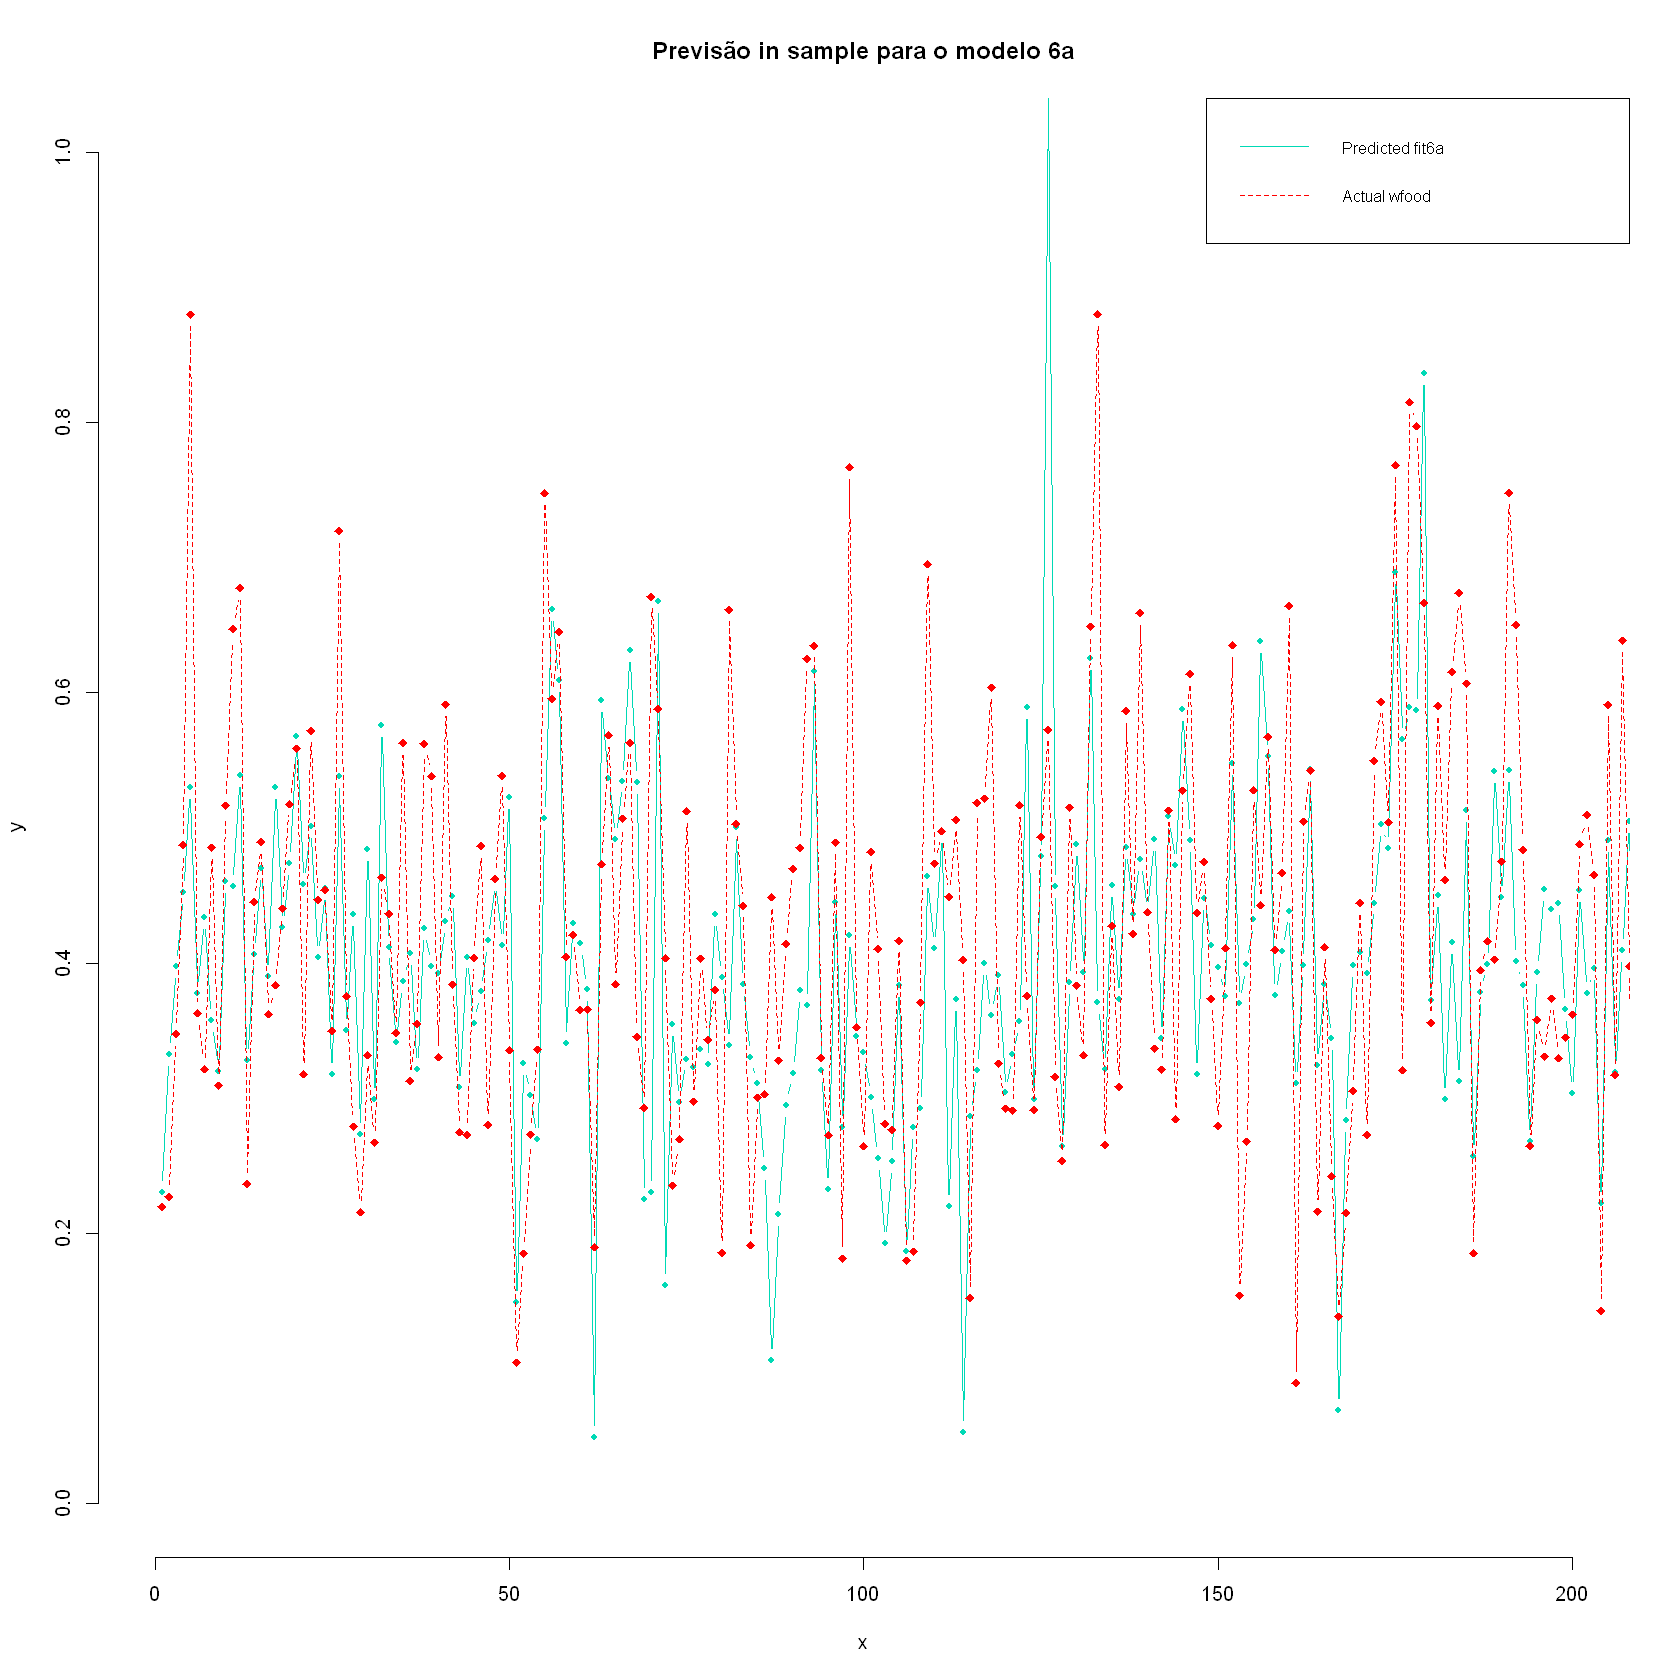

In [109]:
plot(predicted6a, type = "b", frame = FALSE, pch = 20, col = "#00d9b5", xlab = "x", ylab = "y",
     xlim=c(0,200), ylim=c(0,1), main="Previsão in sample para o modelo 6a")

lines(actual6a, pch = 18, col = "red", type = "b", lty = 2, xlim=c(0,200), ylim=c(0,1))

legend("topright", legend=c("Predicted fit6a", "Actual wfood"), col=c("#00d9b5", "red"), lty = 1:2, cex=0.8)


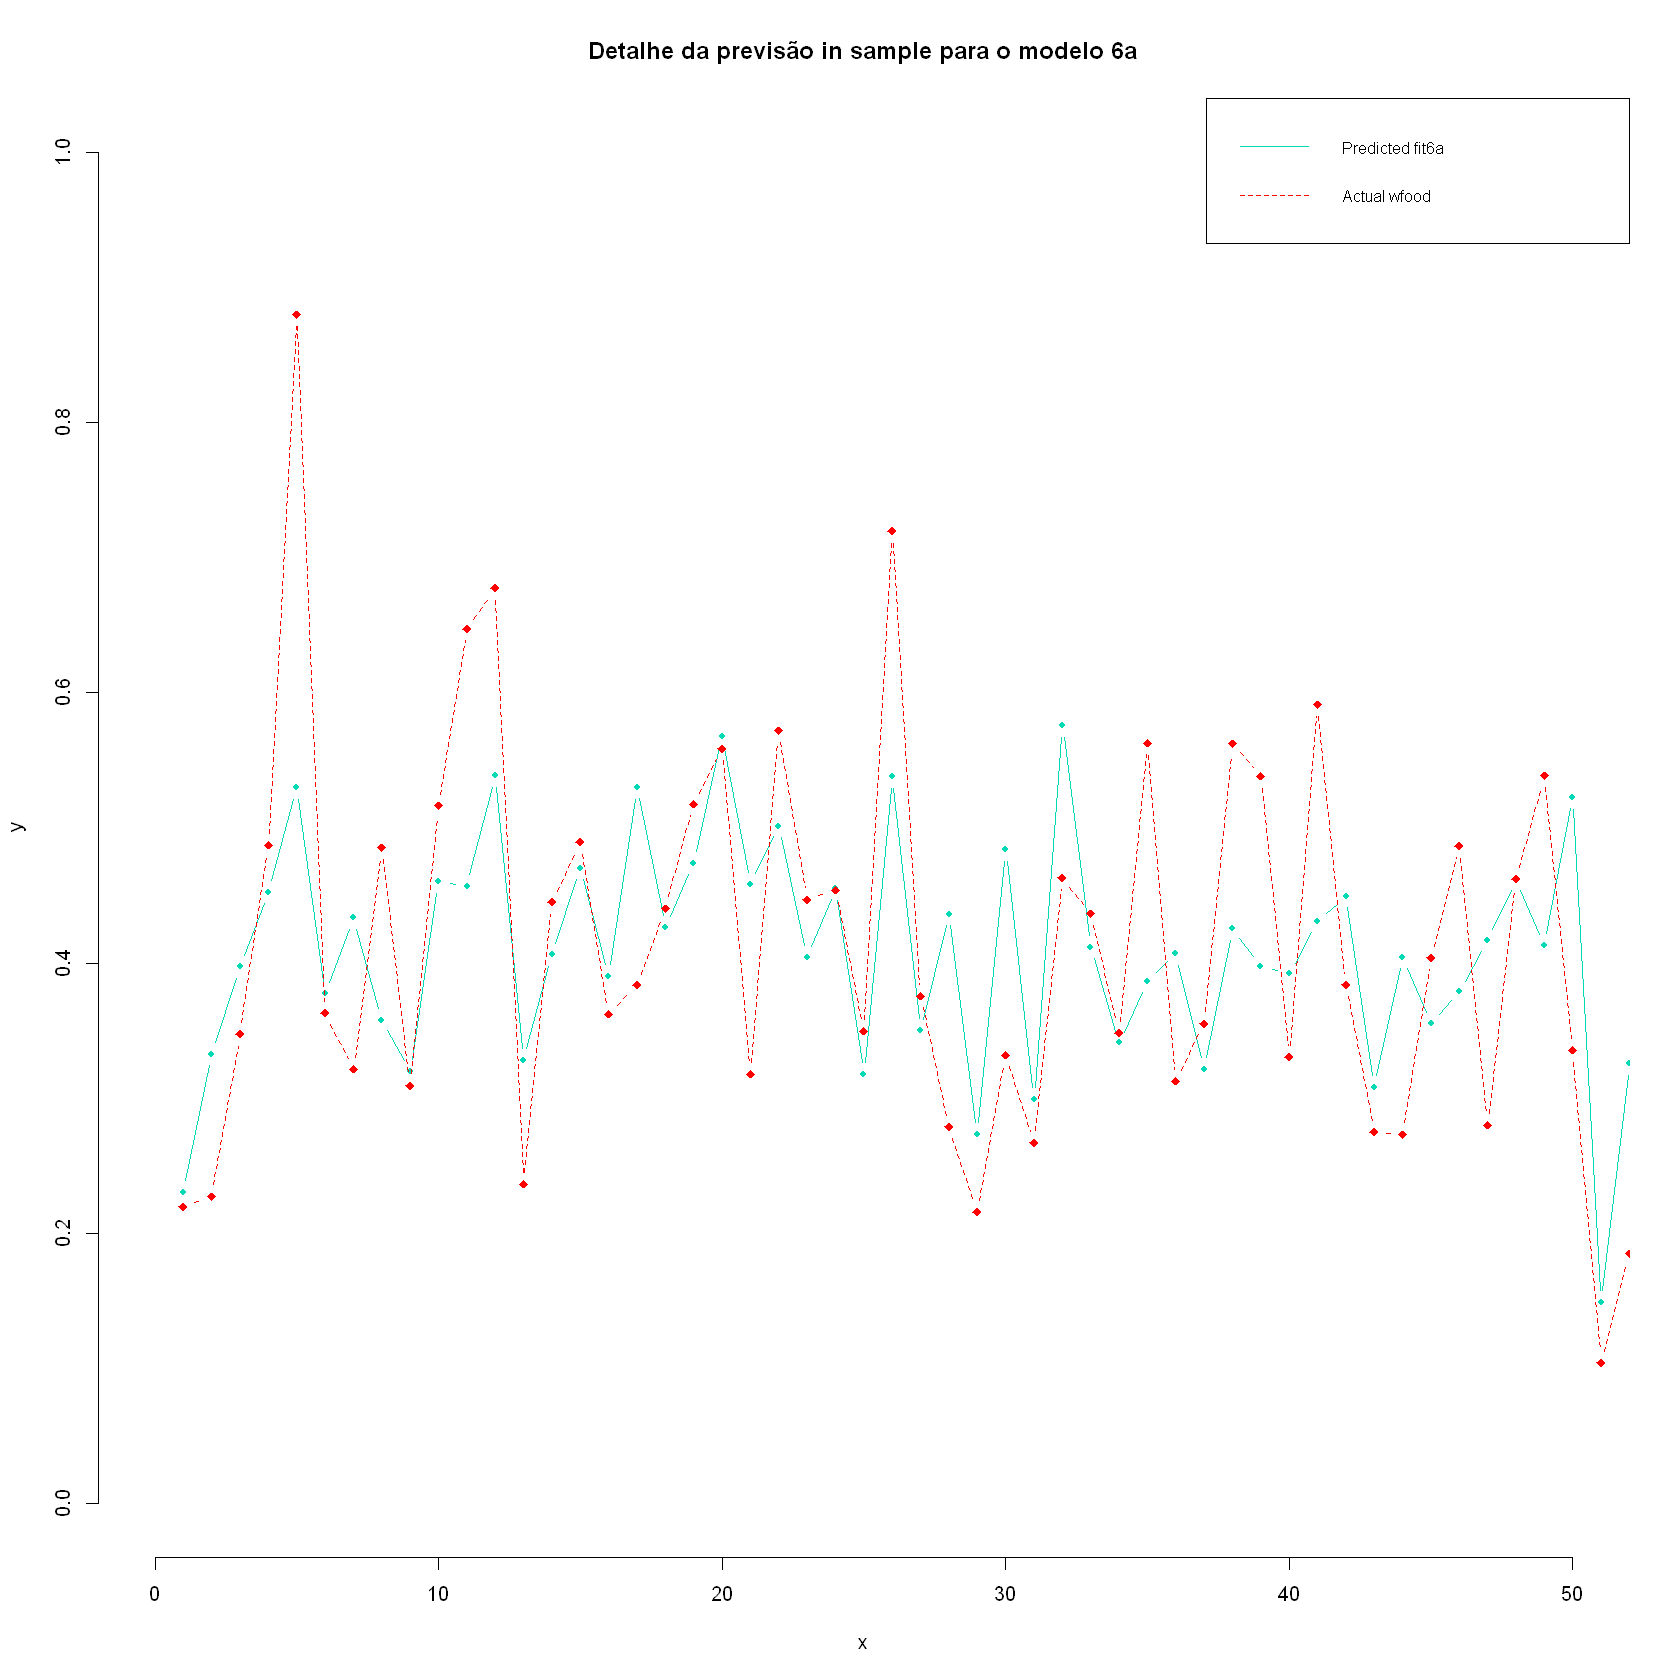

In [110]:
plot(predicted6a, type = "b", frame = FALSE, pch = 20, col = "#00d9b5", xlab = "x", ylab = "y",
     xlim=c(0,50), ylim=c(0,1), main="Detalhe da previsão in sample para o modelo 6a")

lines(actual6a, pch = 18, col = "red", type = "b", lty = 2, xlim=c(0,50), ylim=c(0,1))

legend("topright", legend=c("Predicted fit6a", "Actual wfood"), col=c("#00d9b5", "red"), lty = 1:2, cex=0.8)


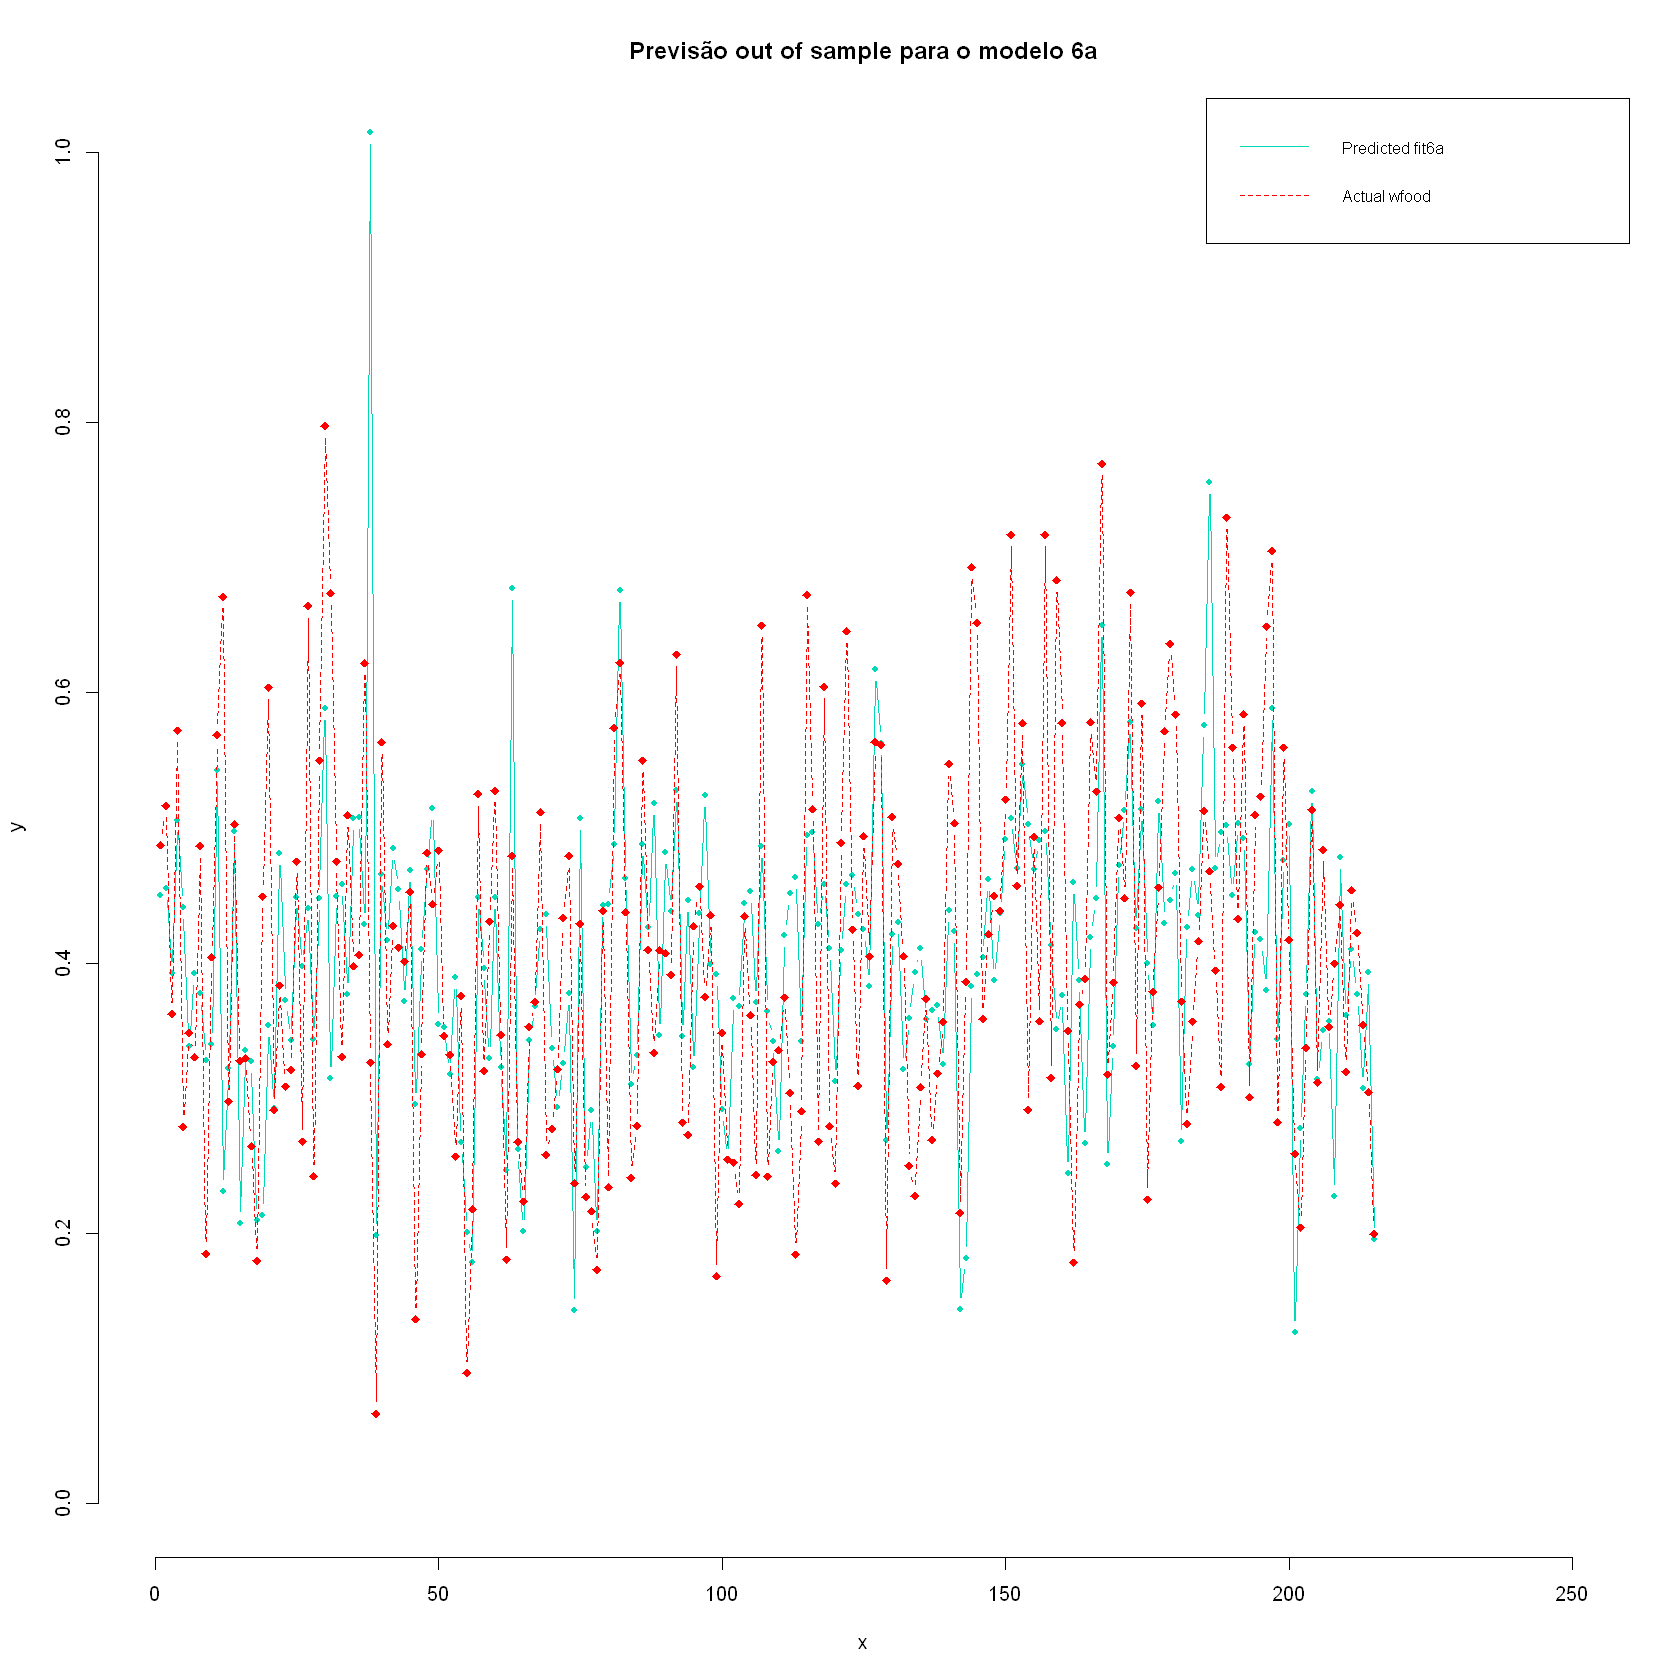

In [111]:
plot(predicted_f6a, type = "b", frame = FALSE, pch = 20, col = "#00d9b5", xlab = "x", ylab = "y",
     xlim=c(0,250), ylim=c(0,1), main="Previsão out of sample para o modelo 6a")

lines(actual_f6a, pch = 18, col = "red", type = "b", lty = 2, xlim=c(0,250), ylim=c(0,1))

legend("topright", legend=c("Predicted fit6a", "Actual wfood"), col=c("#00d9b5", "red"), lty = 1:2, cex=0.8)


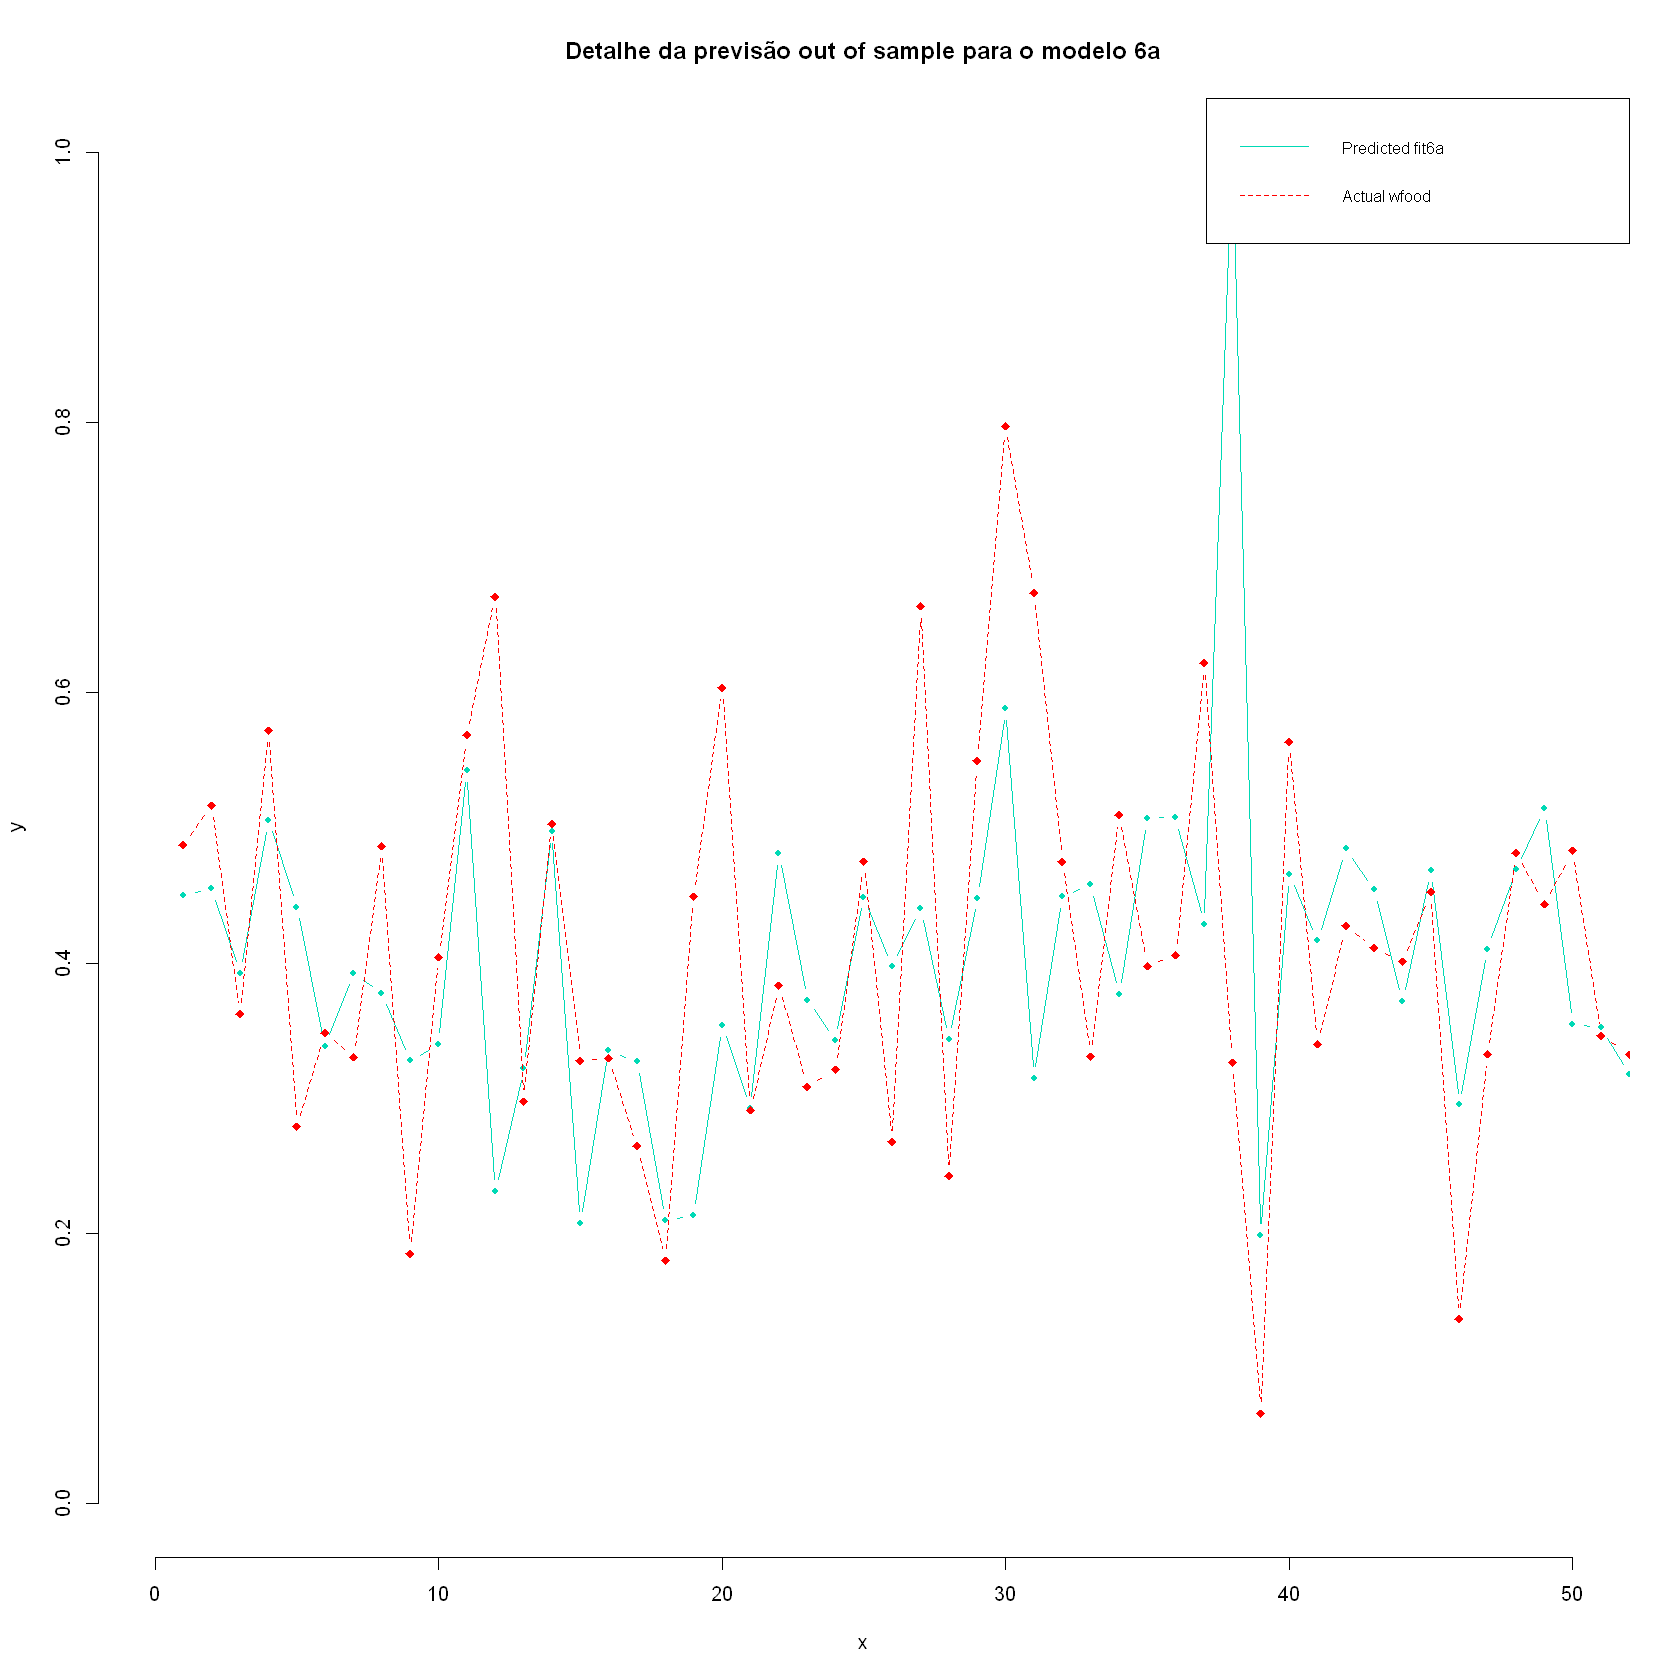

In [112]:
plot(predicted_f6a, type = "b", frame = FALSE, pch = 20, col = "#00d9b5", xlab = "x", ylab = "y",
     xlim=c(0,50), ylim=c(0,1), main="Detalhe da previsão out of sample para o modelo 6a")

lines(actual_f6a, pch = 18, col = "red", type = "b", lty = 2, xlim=c(0,50), ylim=c(0,1))

legend("topright", legend=c("Predicted fit6a", "Actual wfood"), col=c("#00d9b5", "red"), lty = 1:2, cex=0.8)
